# Diamonds
---

Import libraries

In [1]:
import duckdb
import pandas as pd
import numpy as np
import sys
import re
sys.path.insert(0, "../modules")
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
cf.go_offline()

Add the functions

In [2]:

def row_filter(df, cat_var, cat_values):
    df = df[df[cat_var].isin([cat_values])].sort_values(by='price', ascending=False)
    return df.reset_index(drop=True)

def nrow_filter(df, cat_var, cat_values):
    df = df[~df[cat_var].isin([cat_values])].sort_values(by='price', ascending=False)
    return df.reset_index(drop=True)

def groupby_sum(df, group_vars, agg_var='price', sort_var='price'):
    df = df.groupby(group_vars, as_index=False).agg({agg_var:'sum'})
    df = df.sort_values(by=sort_var, ascending=False)
    return df.reset_index(drop=True)

def pivot_table(df, col, x_axis, value='price'):
    df = df.pivot_table(values=value,
                        columns=col,
                        index=x_axis,
                        aggfunc='sum')
    return df.reset_index()

def groupby_median(df, group_vars, agg_var='price/carat', sort_var='price/carat'):
    df = df.groupby(group_vars, as_index=False).agg({agg_var:'median'})
    df = df.sort_values(by=sort_var, ascending=False)
    return df.reset_index(drop=True)

def groupby_mean(df, group_vars, agg_var='price/carat', sort_var='price/carat'):
    df = df.groupby(group_vars, as_index=False).agg({agg_var:'mean'})
    df = df.sort_values(by=sort_var, ascending=False)
    return df.reset_index(drop=True)

### Database adquisition

---

Extract tables

In [3]:
diamonds = duckdb.connect('./diamonds_train.db')
diamonds = diamonds.sql('show tables').df()

In [4]:
diamonds_describe = duckdb.connect('./diamonds_train.db')
diamonds_describe = diamonds_describe.sql('describe').df()

In [5]:
diamonds_city = duckdb.connect('./diamonds_train.db')
diamonds_city = diamonds_city.sql('select * from diamonds_city').df()

In [6]:
diamonds_clarity = duckdb.connect('./diamonds_train.db')
diamonds_clarity = diamonds_clarity.sql('select * from diamonds_clarity').df()

In [7]:
diamonds_color = duckdb.connect('./diamonds_train.db')
diamonds_color = diamonds_color.sql('select * from diamonds_color').df()

In [8]:
diamonds_cut = duckdb.connect('./diamonds_train.db')
diamonds_cut = diamonds_cut.sql('select * from diamonds_cut').df()

In [9]:
diamonds_dimensions = duckdb.connect('./diamonds_train.db')
diamonds_dimensions = diamonds_dimensions.sql('select * from diamonds_dimensions').df()

In [10]:
diamonds_properties = duckdb.connect('./diamonds_train.db')
diamonds_properties = diamonds_properties.sql('select * from diamonds_properties').df()

In [11]:
diamonds_transactional = duckdb.connect('./diamonds_train.db')
diamonds_transactional = diamonds_transactional.sql('select * from diamonds_transactional').df()

Join tables

In [12]:
diamondsall = pd.merge(diamonds_properties,diamonds_transactional, how = 'left', on='index_id')
diamondsall = pd.merge(diamondsall,diamonds_dimensions, how = 'left', on='index_id')
diamondsall = pd.merge(diamondsall,diamonds_cut, how = 'left', on='cut_id')
diamondsall = pd.merge(diamondsall,diamonds_color, how = 'left', on='color_id')
diamondsall = pd.merge(diamondsall,diamonds_clarity, how = 'left', on='clarity_id')
diamondsall = pd.merge(diamondsall,diamonds_city, how = 'left', on='city_id')

Sort the table by price

In [13]:
diamondsall.sort_values(by ='price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
618    ee377871c73631fd6543ddb5164d0b48ea072daa207a91...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
618    de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
618    a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
618    ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
618    89c7286890f7347ab235234e74d406596a127ae3679042...   2.00   60.8   59.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   

          x     y     z        cut color clarity           city  
7034   8.50  8.47  5.16    Premium     I 

### Delete zero values

Seek the zero values of x, y, z (I Know of method describe that there are zeros in)

In [14]:
diamondsdf_x_zero = row_filter(diamondsall, 'x', 0)
diamondsdf_x_zero

index_id  \
0  22207e1ed25c7378b9e7a688e74ae30501008927fb4a3d...   
1  41e2e3dcdbd3996fc30e82e520b032432e1ad19ff94905...   
2  2659730a46782b733d4e18192e92a17ee69b2eaa7538e2...   
3  0c73ebfedfb4af1e074a8cc2e9c530a9ae8fbc79eae5b5...   
4  28c9bf14357dedfba260e2b4052cae63dcede2c4ff513b...   

                                              cut_id  \
0  de88c121a82a06352bf1aaceba20578356408a334ba046...   
1  f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...   
2  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
3  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
4  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   

                                            color_id  \
0  44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
1  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
2  f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...   
3  f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...   
4  f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...   

                                          clarity_id  price  \
0  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...  18034   
1  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...   6381   
2  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   4954   
3  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   2130   
4  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   2130   

                                             city_id  carat  depth  table  \
0  89c7286890f7347ab235234e74d406596a127ae3679042...   2.25   62.8   59.0   
1  ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...   1.14   57.5   67.0   
2  89c7286890f7347ab235234e74d406596a127ae3679042...   1.07   61.6   56.0   
3  e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   0.71   64.1   60.0   
4  89c7286890f7347ab235234e74d406596a127ae3679042...   0.71   64.1   60.0   

     x     y    z      cut color clarity      city  
0  0.0  0.00  0.0  Premium     H     SI2  Kimberly  
1  0.0  0.00  0.0     Fair     G     VS1   Antwerp  
2  0.0  6.62  0.0    Ideal     F     SI2  Kimberly  
3  0.0  0.00  0.0     Good     F     SI2    Madrid  
4  0.0  0.00  0.0     Good     F     SI2  Kimberly

In [15]:
diamondsdf_y_zero = row_filter(diamondsall, 'y', 0)
diamondsdf_y_zero

index_id  \
0  22207e1ed25c7378b9e7a688e74ae30501008927fb4a3d...   
1  41e2e3dcdbd3996fc30e82e520b032432e1ad19ff94905...   
2  0c73ebfedfb4af1e074a8cc2e9c530a9ae8fbc79eae5b5...   
3  28c9bf14357dedfba260e2b4052cae63dcede2c4ff513b...   

                                              cut_id  \
0  de88c121a82a06352bf1aaceba20578356408a334ba046...   
1  f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...   
2  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
3  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   

                                            color_id  \
0  44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
1  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
2  f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...   
3  f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...   

                                          clarity_id  price  \
0  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...  18034   
1  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...   6381   
2  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   2130   
3  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   2130   

                                             city_id  carat  depth  table  \
0  89c7286890f7347ab235234e74d406596a127ae3679042...   2.25   62.8   59.0   
1  ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...   1.14   57.5   67.0   
2  e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   0.71   64.1   60.0   
3  89c7286890f7347ab235234e74d406596a127ae3679042...   0.71   64.1   60.0   

     x    y    z      cut color clarity      city  
0  0.0  0.0  0.0  Premium     H     SI2  Kimberly  
1  0.0  0.0  0.0     Fair     G     VS1   Antwerp  
2  0.0  0.0  0.0     Good     F     SI2    Madrid  
3  0.0  0.0  0.0     Good     F     SI2  Kimberly

In [16]:
diamondsdf_z_zero = row_filter(diamondsall, 'z', 0)
diamondsdf_z_zero

index_id  \
0   c279a17c96f126fc4784ddecd87267c9b8dfc9ed047d4b...   
1   5366ec7df49331f43da1f43fedc75ce2b333ccc2b39fd9...   
2   22207e1ed25c7378b9e7a688e74ae30501008927fb4a3d...   
3   3366cbd949ed025b9bb9a706f82eb6d53993c012e64360...   
4   e832a0253523f9e2e4a0a7bb28f4bf44eb0ca8c38eab12...   
5   105a4d48d04d0d1f1c95676eacd8442d4d2611eab8a107...   
6   41e2e3dcdbd3996fc30e82e520b032432e1ad19ff94905...   
7   fa0cb0b93e1bdf27a23aaf0d8f7a775ec055dd432cc8c6...   
8   2659730a46782b733d4e18192e92a17ee69b2eaa7538e2...   
9   236a75b2ceb98dd392c779cb72c89460f5788d35f9e843...   
10  25d114d44f1ee498521f51cd12e524e8fd6e67c82a9d21...   
11  b7d286a95afa0f5410efa442abe03f1b0182b270035007...   
12  a646d24d01054270efaec7eda44fb8721271d196c55d81...   
13  c9f96f95732be31d3446ba4400a7fe200f252d639074f0...   
14  0c73ebfedfb4af1e074a8cc2e9c530a9ae8fbc79eae5b5...   
15  28c9bf14357dedfba260e2b4052cae63dcede2c4ff513b...   

                                               cut_id  \
0   c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
1   de88c121a82a06352bf1aaceba20578356408a334ba046...   
2   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3   de88c121a82a06352bf1aaceba20578356408a334ba046...   
4   de88c121a82a06352bf1aaceba20578356408a334ba046...   
5   de88c121a82a06352bf1aaceba20578356408a334ba046...   
6   f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...   
7   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
8   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
9   c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
10  de88c121a82a06352bf1aaceba20578356408a334ba046...   
11  de88c121a82a06352bf1aaceba20578356408a334ba046...   
12  de88c121a82a06352bf1aaceba20578356408a334ba046...   
13  de88c121a82a06352bf1aaceba20578356408a334ba046...   
14  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
15  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   

                                             color_id  \
0   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
1   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
2   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
3   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
4   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
5   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
6   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
7   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
8   f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...   
9   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
10  f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...   
11  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
12  44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
13  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
14  f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...   
15  f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...   

                                           clarity_id  price  \
0   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...  18788   
1   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18207   
2   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...  18034   
3   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  17265   
4   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  15397   
5   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...  12631   
6   ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...   6381   
7   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...   5564   
8   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   4954   
9   c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...   4731   
10  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   3837   
11  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   3696   
12  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...   3167   
13  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   3142   
14  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   2130   
15  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...   2130   

                                              

In [17]:
diamondsall = diamondsall.loc[diamondsall['z'] > 0].sort_values(by ='y', ascending = False)
diamondsall

index_id  \
14708  daeb96ce8d169c2a9b958853c724d46352d4749b0ebffa...   
31083  0f1f13ef2ed5183e68c29c8c99f19851b2fc0f226c385d...   
3468   11f4138f4d6ee3c5d5b803a8010f59d227a51fbb2c33f3...   
2884   8835f492a7c86f65d900be580894bbc8f8becf17daa5c2...   
23609  97eae470fe88a1530036f6f95ccb15c9d486a2fc8de1ad...   
...                                                  ...   
8984   946b10af6556fa2a80dec60473a6a50d37971009002005...   
6423   95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...   
23007  927fcdcd5c55b3c3cd828fa8e5d5ce7af4e9096d4b9a0b...   
1582   6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...   
5157   d937ffa207c3d50aeaeb3cd05f1c5e4fef70246a1b3d21...   

                                                  cut_id  \
14708  de88c121a82a06352bf1aaceba20578356408a334ba046...   
31083  f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...   
3468   de88c121a82a06352bf1aaceba20578356408a334ba046...   
2884   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
23609  de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
8984   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
6423   de88c121a82a06352bf1aaceba20578356408a334ba046...   
23007  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
1582   de88c121a82a06352bf1aaceba20578356408a334ba046...   
5157   de88c121a82a06352bf1aaceba20578356408a334ba046...   

                                                color_id  \
14708  44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
31083  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
3468   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
2884   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
23609  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
...                                                  ...   
8984   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
6423   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
23007  3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   
1582   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
5157   3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   

                                              clarity_id  price  \
14708  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...  12210   
31083  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  18531   
3468   c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15223   
2884   c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15984   
23609  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15223   
...                                                  ...    ...   
8984   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    386   
6423   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   
23007  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   
1582   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    345   
5157   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   

                                                 city_id  carat  depth  table  \
14708  5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   2.00   58.9   57.0   
31083  6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...   4.50   65.8   58.0   
3468   ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   4.01   61.0   61.0   
2884   5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   4.00   63.3   58.0   
23609  5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   4.01   62.5   62.0   
...                                                  ...    ...    ...    ...   
8984   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   0.21   63.2   54.0   
6423   ed76f191621cf6ed77eab6a8013d1cb4bdfa89a75a24aa...   0.20   59.8   62.0   
23007  89c7286890f7347ab235234e74d406596a127ae3679042...   0.20   61.5   57.0   
1582   ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...   0.20   60.2   62.0   
5157   ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   0.20   61.7   60.0   

           x      y     z        cut color clarity           city  
14708   8.09  58.90  8.06    Premium   

# Add bins for statistics

Create the function


In [18]:
def price_div(price, div):
    if div == 0:
        return 0
    else:
        return price/div
    
    
def multiply_divide(uno, dos, tres, cuatro):
    resultado = uno * dos * tres / cuatro
    return resultado

### Bin xyz / depth

In [19]:
diamondsall['xyz/depth'] = diamondsall.apply(lambda x : multiply_divide(x['x'], x['y'], x['z'], x['depth']), axis=1)
diamondsall

index_id  \
14708  daeb96ce8d169c2a9b958853c724d46352d4749b0ebffa...   
31083  0f1f13ef2ed5183e68c29c8c99f19851b2fc0f226c385d...   
3468   11f4138f4d6ee3c5d5b803a8010f59d227a51fbb2c33f3...   
2884   8835f492a7c86f65d900be580894bbc8f8becf17daa5c2...   
23609  97eae470fe88a1530036f6f95ccb15c9d486a2fc8de1ad...   
...                                                  ...   
8984   946b10af6556fa2a80dec60473a6a50d37971009002005...   
6423   95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...   
23007  927fcdcd5c55b3c3cd828fa8e5d5ce7af4e9096d4b9a0b...   
1582   6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...   
5157   d937ffa207c3d50aeaeb3cd05f1c5e4fef70246a1b3d21...   

                                                  cut_id  \
14708  de88c121a82a06352bf1aaceba20578356408a334ba046...   
31083  f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...   
3468   de88c121a82a06352bf1aaceba20578356408a334ba046...   
2884   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
23609  de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
8984   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
6423   de88c121a82a06352bf1aaceba20578356408a334ba046...   
23007  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
1582   de88c121a82a06352bf1aaceba20578356408a334ba046...   
5157   de88c121a82a06352bf1aaceba20578356408a334ba046...   

                                                color_id  \
14708  44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
31083  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
3468   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
2884   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
23609  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
...                                                  ...   
8984   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
6423   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
23007  3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   
1582   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
5157   3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   

                                              clarity_id  price  \
14708  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...  12210   
31083  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  18531   
3468   c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15223   
2884   c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15984   
23609  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15223   
...                                                  ...    ...   
8984   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    386   
6423   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   
23007  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   
1582   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    345   
5157   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   

                                                 city_id  carat  depth  table  \
14708  5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   2.00   58.9   57.0   
31083  6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...   4.50   65.8   58.0   
3468   ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   4.01   61.0   61.0   
2884   5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   4.00   63.3   58.0   
23609  5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   4.01   62.5   62.0   
...                                                  ...    ...    ...    ...   
8984   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   0.21   63.2   54.0   
6423   ed76f191621cf6ed77eab6a8013d1cb4bdfa89a75a24aa...   0.20   59.8   62.0   
23007  89c7286890f7347ab235234e74d406596a127ae3679042...   0.20   61.5   57.0   
1582   ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...   0.20   60.2   62.0   
5157   ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   0.20   61.7   60.0   

           x      y     z        cut color clarity           city  xyz/depth  
14708   8.09  58.90  8.06   

### Bin xyz/table

In [20]:
diamondsall['xyz/table'] = diamondsall.apply(lambda x : multiply_divide(x['x'], x['y'], x['z'], x['table']), axis=1)
diamondsall

index_id  \
14708  daeb96ce8d169c2a9b958853c724d46352d4749b0ebffa...   
31083  0f1f13ef2ed5183e68c29c8c99f19851b2fc0f226c385d...   
3468   11f4138f4d6ee3c5d5b803a8010f59d227a51fbb2c33f3...   
2884   8835f492a7c86f65d900be580894bbc8f8becf17daa5c2...   
23609  97eae470fe88a1530036f6f95ccb15c9d486a2fc8de1ad...   
...                                                  ...   
8984   946b10af6556fa2a80dec60473a6a50d37971009002005...   
6423   95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...   
23007  927fcdcd5c55b3c3cd828fa8e5d5ce7af4e9096d4b9a0b...   
1582   6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...   
5157   d937ffa207c3d50aeaeb3cd05f1c5e4fef70246a1b3d21...   

                                                  cut_id  \
14708  de88c121a82a06352bf1aaceba20578356408a334ba046...   
31083  f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...   
3468   de88c121a82a06352bf1aaceba20578356408a334ba046...   
2884   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
23609  de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
8984   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
6423   de88c121a82a06352bf1aaceba20578356408a334ba046...   
23007  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
1582   de88c121a82a06352bf1aaceba20578356408a334ba046...   
5157   de88c121a82a06352bf1aaceba20578356408a334ba046...   

                                                color_id  \
14708  44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
31083  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
3468   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
2884   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
23609  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
...                                                  ...   
8984   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
6423   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
23007  3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   
1582   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
5157   3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   

                                              clarity_id  price  \
14708  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...  12210   
31083  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  18531   
3468   c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15223   
2884   c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15984   
23609  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15223   
...                                                  ...    ...   
8984   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    386   
6423   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   
23007  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   
1582   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    345   
5157   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   

                                                 city_id  carat  depth  table  \
14708  5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   2.00   58.9   57.0   
31083  6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...   4.50   65.8   58.0   
3468   ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   4.01   61.0   61.0   
2884   5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   4.00   63.3   58.0   
23609  5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   4.01   62.5   62.0   
...                                                  ...    ...    ...    ...   
8984   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   0.21   63.2   54.0   
6423   ed76f191621cf6ed77eab6a8013d1cb4bdfa89a75a24aa...   0.20   59.8   62.0   
23007  89c7286890f7347ab235234e74d406596a127ae3679042...   0.20   61.5   57.0   
1582   ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...   0.20   60.2   62.0   
5157   ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   0.20   61.7   60.0   

           x      y     z        cut color clarity           city  xyz/depth  \
14708   8.09  58.90  8.06  

### Bin of xyz/carat

In [21]:
diamondsall['xyz/carat'] = diamondsall.apply(lambda x : multiply_divide(x['x'], x['y'], x['z'], x['carat']), axis=1)
diamondsall

index_id  \
14708  daeb96ce8d169c2a9b958853c724d46352d4749b0ebffa...   
31083  0f1f13ef2ed5183e68c29c8c99f19851b2fc0f226c385d...   
3468   11f4138f4d6ee3c5d5b803a8010f59d227a51fbb2c33f3...   
2884   8835f492a7c86f65d900be580894bbc8f8becf17daa5c2...   
23609  97eae470fe88a1530036f6f95ccb15c9d486a2fc8de1ad...   
...                                                  ...   
8984   946b10af6556fa2a80dec60473a6a50d37971009002005...   
6423   95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...   
23007  927fcdcd5c55b3c3cd828fa8e5d5ce7af4e9096d4b9a0b...   
1582   6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...   
5157   d937ffa207c3d50aeaeb3cd05f1c5e4fef70246a1b3d21...   

                                                  cut_id  \
14708  de88c121a82a06352bf1aaceba20578356408a334ba046...   
31083  f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...   
3468   de88c121a82a06352bf1aaceba20578356408a334ba046...   
2884   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
23609  de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
8984   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
6423   de88c121a82a06352bf1aaceba20578356408a334ba046...   
23007  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
1582   de88c121a82a06352bf1aaceba20578356408a334ba046...   
5157   de88c121a82a06352bf1aaceba20578356408a334ba046...   

                                                color_id  \
14708  44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
31083  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
3468   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
2884   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
23609  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
...                                                  ...   
8984   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
6423   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
23007  3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   
1582   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
5157   3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   

                                              clarity_id  price  \
14708  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...  12210   
31083  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  18531   
3468   c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15223   
2884   c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15984   
23609  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...  15223   
...                                                  ...    ...   
8984   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    386   
6423   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   
23007  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   
1582   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    345   
5157   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    367   

                                                 city_id  carat  depth  table  \
14708  5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   2.00   58.9   57.0   
31083  6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...   4.50   65.8   58.0   
3468   ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   4.01   61.0   61.0   
2884   5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   4.00   63.3   58.0   
23609  5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   4.01   62.5   62.0   
...                                                  ...    ...    ...    ...   
8984   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   0.21   63.2   54.0   
6423   ed76f191621cf6ed77eab6a8013d1cb4bdfa89a75a24aa...   0.20   59.8   62.0   
23007  89c7286890f7347ab235234e74d406596a127ae3679042...   0.20   61.5   57.0   
1582   ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...   0.20   60.2   62.0   
5157   ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   0.20   61.7   60.0   

           x      y     z        cut color clarity           city  xyz/depth  \
14708   8.09  58.90  8.06  

### Bin of price/carat

In [22]:
diamondsall['price/carat'] = diamondsall.apply(lambda x : price_div(x['price'], x['carat']), axis=1)
diamondsall.sort_values(by = 'price/carat', ascending = False)

index_id  \
30617  4bbcec8e814749f2b038f5c0f4bfd06c039d8a510ec58f...   
2195   5bc05e241527d767aae5d0921978e11918f632b8cefc1d...   
19719  5f4b75634381196faf857ccc46a291a90b75e7406c66a5...   
21405  51bc63526c24a8a11da622ceb64e6c0831fa18cbc5adbb...   
2713   75ab3e0a8f99144f9c4420698980b6f76f85996b520937...   
...                                                  ...   
29931  6b79358b06544b0b56ae3a05e7b60b9acd2320b1074562...   
29172  0327d5e69f5556cfbd69f4d40e05ff0ceeaa2f569c732c...   
36959  d63d53e3d4dd0722425e374f01a9aed9c02ab2c9b336c9...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
40057  b98ff56fbc0b30e5428accf45fb42ea2010c62a2e5907b...   

                                                  cut_id  \
30617  388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
2195   de88c121a82a06352bf1aaceba20578356408a334ba046...   
19719  388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
21405  388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
2713   c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
...                                                  ...   
29931  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
29172  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
36959  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
40057  de88c121a82a06352bf1aaceba20578356408a334ba046...   

                                                color_id  \
30617  3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   
2195   3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   
19719  3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   
21405  3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   
2713   3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   
...                                                  ...   
29931  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
29172  3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...   
36959  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
40057  44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   

                                              clarity_id  price  \
30617  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18542   
2195   7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18279   
19719  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18114   
21405  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  17100   
2713   7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  15928   
...                                                  ...    ...   
29931  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    339   
29172  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...    361   
36959  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    344   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
40057  c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...    452   

                                                 city_id  carat  depth  table  \
30617  0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   1.04   61.3   56.0   
2195   1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   1.07   60.9   58.0   
19719  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   1.07   60.9   58.0   
21405  89c7286890f7347ab235234e74d406596a127ae3679042...   1.02   61.7   59.0   
2713   ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   1.00   63.3   59.0   
...                                                  ...    ...    ...    ...   
29931  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.30   64.0   55.0   
29172  e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   0.32   64.0   54.0   
36959  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   0.31   62.2   54.0   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
40057  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.43   62.0   59.0   

          x     y     z        cut color clarity       city  xyz/depth  \
30617  6.53  6.55  4.01  Very Goo

### Bin of price/depth

In [23]:
diamondsall['price/depth'] = diamondsall.apply(lambda x : price_div(x['price'], x['depth']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...     z        cut color clarity           city xyz/depth  \
7034   8.50  ...  5.16    Premi

### Bin of price/table

In [24]:
diamondsall['price/table'] = diamondsall.apply(lambda x : price_div(x['price'], x['table']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...        cut  color clarity           city xyz/depth xyz/table  \
7034   8.50  ...    Premiu

### Bin of price/x

In [25]:
diamondsall['price/x'] = diamondsall.apply(lambda x : price_div(x['price'], x['x']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...  color  clarity           city xyz/depth xyz/table  \
7034   8.50  ...      I      VS2    

### Bin price/y

In [26]:
diamondsall['price/y'] = diamondsall.apply(lambda x : price_div(x['price'], x['y']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...  clarity           city xyz/depth xyz/table   xyz/carat  \
7034   8.50  ...      VS2      

### Bin price/z

In [27]:
diamondsall['price/z'] = diamondsall.apply(lambda x : price_div(x['price'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...           city  xyz/depth xyz/table   xyz/carat  \
7034   8.50  ...       Kimberly   6.110

## Bin depth/table

In [28]:
diamondsall['depth/table'] = diamondsall.apply(lambda x : price_div(x['depth'], x['table']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...  xyz/depth  xyz/table   xyz/carat   price/carat price/depth  \
7034   8.50  ...   6.110102

## Bin depth/z

In [29]:
diamondsall['depth/z'] = diamondsall.apply(lambda x : price_div(x['depth'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...  xyz/table   xyz/carat   price/carat price/depth price/table  \
7034   8.50  ...   6.19157

## Bin depth/carat

In [30]:
diamondsall['depth/carat'] = diamondsall.apply(lambda x : price_div(x['depth'], x['carat']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...   xyz/carat   price/carat price/depth price/table  \
7034   8.50  ...  162.224541   8219.6

## Bin table/z

In [31]:
diamondsall['table/z'] = diamondsall.apply(lambda x : price_div(x['table'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...   price/carat  price/depth price/table      price/x  \
7034   8.50  ...   8219.650655   30

## Bin table/carat

In [32]:
diamondsall['table/carat'] = diamondsall.apply(lambda x : price_div(x['table'], x['carat']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...  price/depth  price/table      price/x      price/y  \
7034   8.50  ...   309.588816   313

## Bin carat/z

In [33]:
diamondsall['carat/z'] = diamondsall.apply(lambda x : price_div(x['carat'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...  price/table      price/x      price/y      price/z  \
7034   8.50  ...   313.716667  2214

## Bin x/z

In [34]:
diamondsall['x/z'] = diamondsall.apply(lambda x : price_div(x['x'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...      price/x      price/y      price/z depth/table  \
7034   8.50  ...  2214.470588  2222.

## Bin y/z

In [35]:
diamondsall['y/z'] = diamondsall.apply(lambda x : price_div(x['y'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...      price/y      price/z depth/table    depth/z depth/carat  \
7034   8.50  ...  2222.314

## Bin x/y

In [36]:
diamondsall['x/y'] = diamondsall.apply(lambda x : price_div(x['x'], x['y']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

index_id  \
7034   0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...   
3990   ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...   
29107  8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...   
25529  57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...   
6912   153de641ea0557acad28b609f949ec7ad909c0168b9af1...   
...                                                  ...   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...   
20968  c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...   
18381  b3884138875a4fff84c082069e1f4adc178c3642c8b872...   
18377  a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...   
9782   257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...   

                                                  cut_id  \
7034   de88c121a82a06352bf1aaceba20578356408a334ba046...   
3990   388655e25e91872329272fc10128ef5354b3b19a05d7e8...   
29107  4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   
25529  de88c121a82a06352bf1aaceba20578356408a334ba046...   
6912   de88c121a82a06352bf1aaceba20578356408a334ba046...   
...                                                  ...   
12084  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
20968  de88c121a82a06352bf1aaceba20578356408a334ba046...   
18381  c939327ca16dcf97ca32521d8b834bf1de16573d21deda...   
18377  de88c121a82a06352bf1aaceba20578356408a334ba046...   
9782   4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...   

                                                color_id  \
7034   a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
3990   333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
29107  333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...   
25529  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
6912   44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...   
...                                                  ...   
12084  6da43b944e494e885e69af021f93c6d9331c78aa228084...   
20968  a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...   
18381  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
18377  a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   
9782   a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...   

                                              clarity_id  price  \
7034   f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...  18823   
3990   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18818   
29107  7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...  18806   
25529  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18797   
6912   bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...  18795   
...                                                  ...    ...   
12084  03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    335   
20968  f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...    334   
18381  ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...    327   
18377  bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...    326   
9782   03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...    326   

                                                 city_id  carat  depth  table  \
7034   89c7286890f7347ab235234e74d406596a127ae3679042...   2.29   60.8   60.0   
3990   e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...   2.00   63.5   56.0   
29107  5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...   1.51   61.7   55.0   
25529  ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...   2.29   61.8   59.0   
6912   0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...   2.04   58.1   60.0   
...                                                  ...    ...    ...    ...   
12084  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.31   63.3   58.0   
20968  89c7286890f7347ab235234e74d406596a127ae3679042...   0.29   62.4   58.0   
18381  1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...   0.23   56.9   65.0   
18377  68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...   0.21   59.8   61.0   
9782   5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...   0.23   61.5   55.0   

          x  ...      price/z  depth/table    depth/z depth/carat    table/z  \
7034   8.50  ...  3647.8682

### Bin for add a number for categoricals city, cut, color, clarity

Create the function for:

In [37]:
# Here the function

In [38]:
diamondsall['cut'].unique()

array(['Premium', 'Fair', 'Very Good', 'Ideal', 'Good'], dtype=object)

In [39]:
diamondsall['city'].unique()

array(['Paris', 'Dubai', 'Surat', 'New York City', 'London', 'Kimberly',
       'Zurich', 'Antwerp', 'Madrid', 'Tel Aviv', 'Luxembourg',
       'Las Vegas', 'Amsterdam'], dtype=object)

In [40]:
diamonds_sort_color = diamondsall['color'].unique()
diamonds_sort_color = np.sort(diamonds_sort_color)
diamonds_sort_color

array(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object)

In [41]:
for i in range(len(diamonds_sort_color)):
    count = 1
    i = count
    count = count + 1

In [42]:
diamondsall['clarity'].unique()

array(['SI2', 'I1', 'VS2', 'SI1', 'VS1', 'IF', 'VVS1', 'VVS2'],
      dtype=object)

In [43]:
'''
If 'string' = 'string'
string == number
'''

"\nIf 'string' = 'string'\nstring == number\n"

### Select the columns

In [44]:
diamondsdf = diamondsall.drop(['cut_id', 'color_id', 'clarity_id', 'city_id'],  axis = 1)
diamondsdf.sort_values(by = 'price/carat', ascending = False)

index_id  price  carat  depth  \
30617  4bbcec8e814749f2b038f5c0f4bfd06c039d8a510ec58f...  18542   1.04   61.3   
2195   5bc05e241527d767aae5d0921978e11918f632b8cefc1d...  18279   1.07   60.9   
19719  5f4b75634381196faf857ccc46a291a90b75e7406c66a5...  18114   1.07   60.9   
21405  51bc63526c24a8a11da622ceb64e6c0831fa18cbc5adbb...  17100   1.02   61.7   
2713   75ab3e0a8f99144f9c4420698980b6f76f85996b520937...  15928   1.00   63.3   
...                                                  ...    ...    ...    ...   
29931  6b79358b06544b0b56ae3a05e7b60b9acd2320b1074562...    339   0.30   64.0   
29172  0327d5e69f5556cfbd69f4d40e05ff0ceeaa2f569c732c...    361   0.32   64.0   
36959  d63d53e3d4dd0722425e374f01a9aed9c02ab2c9b336c9...    344   0.31   62.2   
12084  5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...    335   0.31   63.3   
40057  b98ff56fbc0b30e5428accf45fb42ea2010c62a2e5907b...    452   0.43   62.0   

       table     x     y     z        cut color  ...      price/z depth/table  \
30617   56.0  6.53  6.55  4.01  Very Good     D  ...  4623.940150    1.094643   
2195    58.0  6.67  6.57  4.03    Premium     D  ...  4535.732010    1.050000   
19719   58.0  6.57  6.67  4.03  Very Good     D  ...  4494.789082    1.050000   
21405   59.0  6.42  6.52  3.99  Very Good     D  ...  4285.714286    1.045763   
2713    59.0  6.33  6.37  4.02       Good     D  ...  3962.189055    1.072881   
...      ...   ...   ...   ...        ...   ...  ...          ...         ...   
29931   55.0  4.25  4.28  2.73       Good     J  ...   124.175824    1.163636   
29172   54.0  4.33  4.36  2.78       Good     D  ...   129.856115    1.185185   
36959   54.0  4.35  4.37  2.71      Ideal     J  ...   126.937269    1.151852   
12084   58.0  4.34  4.35  2.75       Good     J  ...   121.818182    1.091379   
40057   59.0  4.78  4.83  2.98    Premium     H  ...   151.677852    1.050847   

         depth/z  depth/carat    table/z  table/carat   carat/z       x/z  \
30617  15.286783    58.942308  13.965087    53.846154  0.259352  1.628429   
2195   15.111663    56.915888  14.392060    54.205607  0.265509  1.655087   
19719  15.111663    56.915888  14.392060    54.205607  0.265509  1.630273   
21405  15.463659    60.490196  14.786967    57.843137  0.255639  1.609023   
2713   15.746269    63.300000  14.676617    59.000000  0.248756  1.574627   
...          ...          ...        ...          ...       ...       ...   
29931  23.443223   213.333333  20.146520   183.333333  0.109890  1.556777   
29172  23.021583   200.000000  19.424460   168.750000  0.115108  1.557554   
36959  22.952030   200.645161  19.926199   174.193548  0.114391  1.605166   
12084  23.018182   204.193548  21.090909   187.096774  0.112727  1.578182   
40057  20.805369   144.186047  19.798658   137.209302  0.144295  1.604027   

            y/z       x/y  
30617  1.633416  0.996947  
2195   1.630273  1.015221  
19719  1.655087  0.985007  
21405  1.634085  0.984663  
2713   1.584577  0.993721  
...         ...       ...  
29931  1.567766  0.992991  
29172  1.568345  0.993119  
36959  1.612546  0.995423  
12084  1.581818  0.997701  
40057  1.620805  0.989648  

[40439 rows x 30 columns]

Move index to the last

In [45]:
new_cols = ['price', 'carat', 'depth', 'table', 'x', 'y', 'z', 'cut',
       'color', 'clarity', 'city', 'price/carat', 'price/depth', 'price/table',
       'price/x', 'price/y', 'price/z', 'depth/table', 'depth/z',
       'depth/carat', 'table/z', 'table/carat', 'carat/z', 'x/z', 'y/z',
       'x/y', 'xyz/depth', 'xyz/table', 'xyz/carat', 'index_id']
diamondsdf = diamondsdf[new_cols]
diamondsdf.sort_values(by = 'xyz/table')

price  carat  depth  table      x      y     z        cut color  \
1582     345   0.20   60.2   62.0   3.79   3.75  2.27    Premium     E   
6423     367   0.20   59.8   62.0   3.79   3.77  2.26    Premium     E   
6550     367   0.20   59.7   62.0   3.84   3.80  2.28    Premium     E   
5157     367   0.20   61.7   60.0   3.77   3.72  2.31    Premium     D   
37671    369   0.23   61.4   66.0   3.87   3.91  2.39       Fair     G   
...      ...    ...    ...    ...    ...    ...   ...        ...   ...   
27893  17329   4.13   64.8   61.0  10.00   9.85  6.43       Fair     H   
20432  15964   3.40   66.8   52.0   9.42   9.34  6.27       Fair     D   
2884   15984   4.00   63.3   58.0  10.01   9.94  6.31  Very Good     I   
31083  18531   4.50   65.8   58.0  10.23  10.16  6.72       Fair     J   
14708  12210   2.00   58.9   57.0   8.09  58.90  8.06    Premium     H   

      clarity  ...    table/z  table/carat   carat/z       x/z       y/z  \
1582      SI2  ...  27.312775   310.000000  0.088106  1.669604  1.651982   
6423      VS2  ...  27.433628   310.000000  0.088496  1.676991  1.668142   
6550      VS2  ...  27.192982   310.000000  0.087719  1.684211  1.666667   
5157      VS2  ...  25.974026   300.000000  0.086580  1.632035  1.610390   
37671    VVS2  ...  27.615063   286.956522  0.096234  1.619247  1.635983   
...       ...  ...        ...          ...       ...       ...       ...   
27893      I1  ...   9.486781    14.769976  0.642302  1.555210  1.531882   
20432      I1  ...   8.293461    15.294118  0.542265  1.502392  1.489633   
2884       I1  ...   9.191759    14.500000  0.633914  1.586371  1.575277   
31083      I1  ...   8.630952    12.888889  0.669643  1.522321  1.511905   
14708     SI2  ...   7.071960    28.500000  0.248139  1.003722  7.307692   

            x/y  xyz/depth  xyz/table    xyz/carat  \
1582   1.010667   0.535920   0.520361   161.311875   
6423   1.005305   0.539993   0.520832   161.457790   
6550   1.010526   0.557282   0.536609   166.348800   
5157   1.013441   0.525063   0.539939   161.981820   
37671  0.989770   0.589003   0.547951   157.238100   
...         ...        ...        ...          ...   
27893  1.015228   9.773997  10.382869   153.354722   
20432  1.008565   8.258266  10.608695   162.250634   
2884   1.007042   9.918503  10.824849   156.960303   
31083  1.006890  10.614822  12.042333   155.212288   
14708  0.137351  65.205400  67.378913  1920.299030   

                                                index_id  
1582   6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...  
6423   95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...  
6550   e1299b1fe6306876f5135f76e0403dd88c18ef5d0e1352...  
5157   d937ffa207c3d50aeaeb3cd05f1c5e4fef70246a1b3d21...  
37671  4964474ad44f2c8ce781aaf323cc8b73547f2cdf7e83d3...  
...                                                  ...  
27893  bd1fcf458ac3909b63648659afad8f05b05a868261ba59...  
20432  83e86276134048f50522b4944d21f8a52004f7b138b58c...  
2884   8835f492a7c86f65d900be580894bbc8f8becf17daa5c2...  
31083  0f1f13ef2ed5183e68c29c8c99f19851b2fc0f226c385d...  
14708  daeb96ce8d169c2a9b958853c724d46352d4749b0ebffa...  

[40439 rows x 30 columns]

In [122]:
diamondsdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40439 entries, 14708 to 5157
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        40439 non-null  int64  
 1   carat        40439 non-null  float64
 2   depth        40439 non-null  float64
 3   table        40439 non-null  float64
 4   x            40439 non-null  float64
 5   y            40439 non-null  float64
 6   z            40439 non-null  float64
 7   cut          40439 non-null  object 
 8   color        40439 non-null  object 
 9   clarity      40439 non-null  object 
 10  city         40439 non-null  object 
 11  price/carat  40439 non-null  float64
 12  price/depth  40439 non-null  float64
 13  price/table  40439 non-null  float64
 14  price/x      40439 non-null  float64
 15  price/y      40439 non-null  float64
 16  price/z      40439 non-null  float64
 17  depth/table  40439 non-null  float64
 18  depth/z      40439 non-null  float64
 19  d

## Statatistics of dataframe

In [47]:
diamondsdf.describe()

price         carat         depth         table             x  \
count  40439.000000  40439.000000  40439.000000  40439.000000  40439.000000   
mean    3926.535448      0.797425     61.753013     57.445543      5.729616   
std     3990.024501      0.475257      1.431306      2.233055      1.122384   
min      326.000000      0.200000     43.000000     43.000000      3.770000   
25%      945.000000      0.400000     61.000000     56.000000      4.710000   
50%     2396.000000      0.700000     61.800000     57.000000      5.690000   
75%     5329.500000      1.040000     62.500000     59.000000      6.540000   
max    18823.000000      4.500000     79.000000     95.000000     10.230000   

                  y             z   price/carat   price/depth   price/table  \
count  40439.000000  40439.000000  40439.000000  40439.000000  40439.000000   
mean       5.732897      3.538553   4002.088355     63.644260     68.100677   
std        1.145002      0.693639   2009.743301     64.801531     69.019607   
min        3.720000      1.070000   1051.162791      5.176651      5.030769   
25%        4.720000      2.910000   2470.551039     15.316045     16.677966   
50%        5.710000      3.520000   3492.156863     38.924559     41.821429   
75%        6.540000      4.040000   4945.697168     86.441615     92.383333   
max       58.900000      8.060000  17828.846154    325.852373    354.615385   

       ...   depth/carat       table/z   table/carat       carat/z  \
count  ...  40439.000000  40439.000000  40439.000000  40439.000000   
mean   ...    108.058491     16.837752    100.163668      0.209279   
std    ...     59.900228      3.206038     55.148135      0.083363   
min    ...     14.622222      7.071960     12.888889      0.080128   
25%    ...     58.605556     14.181589     54.545455      0.135593   
50%    ...     87.887324     16.477273     81.690141      0.199438   
75%    ...    156.052632     19.642857    145.000000      0.261307   
max    ...    308.500000     53.271028    310.000000      1.000000   

                x/z           y/z           x/y     xyz/depth     xyz/table  \
count  40439.000000  40439.000000  40439.000000  40439.000000  40439.000000   
mean       1.619816      1.621020      0.999394      2.103899      2.254834   
std        0.047821      0.055966      0.011211      1.283447      1.358854   
min        0.990119      0.996047      0.137351      0.525063      0.520361   
25%        1.598101      1.599379      0.992606      1.048033      1.132155   
50%        1.615819      1.618861      0.995736      1.852064      1.981068   
75%        1.637593      1.640103      1.006928      2.794950      2.992740   
max        6.186916      7.307692      1.615572     65.205400     67.378913   

          xyz/carat  
count  40439.000000  
mean     163.343097  
std        9.561303  
min       44.155400  
25%      161.554662  
50%      163.483086  
75%      165.347706  
max     1920.299030  

[8 rows x 25 columns]

### Correlations

In [48]:
diamondsdf.corr()

C:\Users\marym\AppData\Local\Temp\ipykernel_4676\2783921700.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



price     carat     depth     table         x         y  \
price        1.000000  0.921881 -0.014923  0.130170  0.887850  0.867756   
carat        0.921881  1.000000  0.026585  0.183347  0.977901  0.953386   
depth       -0.014923  0.026585  1.000000 -0.293093 -0.026190 -0.030803   
table        0.130170  0.183347 -0.293093  1.000000  0.197229  0.185826   
x            0.887850  0.977901 -0.026190  0.197229  1.000000  0.974044   
y            0.867756  0.953386 -0.030803  0.185826  0.974044  1.000000   
z            0.882131  0.976326  0.094575  0.157398  0.990932  0.971019   
price/carat  0.911957  0.769713 -0.041307  0.088329  0.790766  0.773846   
price/depth  0.999427  0.920004 -0.039779  0.137159  0.887654  0.867785   
price/table  0.998647  0.918148 -0.003679  0.093791  0.884619  0.864897   
price/x      0.993285  0.904470 -0.006347  0.124807  0.887605  0.867894   
price/y      0.993389  0.905458 -0.005520  0.126302  0.888540  0.865267   
price/z      0.992651  0.902867 -0.034601  0.133449  0.887929  0.866717   
depth/table -0.109113 -0.129768  0.680410 -0.897370 -0.164440 -0.157993   
depth/z     -0.820107 -0.923635  0.022725 -0.192581 -0.979312 -0.956634   
depth/carat -0.741737 -0.857670  0.005743 -0.194474 -0.938242 -0.914567   
table/z     -0.798997 -0.896846 -0.153284  0.045430 -0.943347 -0.922400   
table/carat -0.740774 -0.855720 -0.049942 -0.116166 -0.933881 -0.910574   
carat/z      0.907649  0.992140 -0.006243  0.205308  0.991961  0.964934   
x/z          0.030206  0.009529 -0.767823  0.263671  0.055753  0.033849   
y/z          0.003477 -0.028786 -0.676477  0.182256  0.004370  0.124454   
x/y          0.083176  0.132225  0.057203  0.131158  0.148483  0.015060   
xyz/depth    0.898610  0.969386 -0.037280  0.180877  0.952497  0.980448   
xyz/table    0.899266  0.969698  0.026249  0.106608  0.950101  0.977021   
xyz/carat   -0.059286 -0.088094 -0.153829 -0.119489 -0.079962  0.127389   

                    z  price/carat  price/depth  price/table  ...  \
price        0.882131     0.911957     0.999427     0.998647  ...   
carat        0.976326     0.769713     0.920004     0.918148  ...   
depth        0.094575    -0.041307    -0.039779    -0.003679  ...   
table        0.157398     0.088329     0.137159     0.093791  ...   
x            0.990932     0.790766     0.887654     0.884619  ...   
y            0.971019     0.773846     0.867785     0.864897  ...   
z            1.000000     0.782961     0.878530     0.880661  ...   
price/carat  0.782961     1.000000     0.912043     0.914035  ...   
price/depth  0.878530     0.912043     1.000000     0.997507  ...   
price/table  0.880661     0.914035     0.997507     1.000000  ...   
price/x      0.883476     0.950302     0.992272     0.992909  ...   
price/y      0.883864     0.949415     0.992343     0.992916  ...   
price/z      0.878418     0.949935     0.992834     0.991649  ...   
depth/table -0.079129    -0.090269    -0.125720    -0.076304  ...   
depth/z     -0.974975    -0.771161    -0.819612    -0.817812  ...   
depth/carat -0.933403    -0.727653    -0.740742    -0.739905  ...   
table/z     -0.960409    -0.753540    -0.794803    -0.804103  ...   
table/carat -0.935339    -0.726958    -0.738947    -0.740665  ...   
carat/z      0.983710     0.783018     0.906884     0.903486  ...   
x/z         -0.066036     0.044799     0.049181     0.020494  ...   
y/z         -0.081578     0.022167     0.020390    -0.003377  ...   
x/y          0.121997     0.056672     0.081739     0.079032  ...   
xyz/depth    0.948628     0.752911     0.899153     0.894737  ...   
xyz/table    0.954777     0.755446     0.897479     0.899671  ...   
xyz/carat   -0.072261    -0.046812    -0.054637    -0.055613  ...   

             depth/carat   table/z  table/carat   carat/z       x/z       y/z  \
price          -0.741737 -0.798997    -0.740774  0.907649  0.030206  0.003477   
carat          -0.857670 -0.896846    -0.855720  0.992140  0.009529 -0.028786   
depth           0.005743 -0

### Median

In [49]:
diamondsdf.median()

C:\Users\marym\AppData\Local\Temp\ipykernel_4676\1315274457.py:1: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



price          2396.000000
carat             0.700000
depth            61.800000
table            57.000000
x                 5.690000
y                 5.710000
z                 3.520000
price/carat    3492.156863
price/depth      38.924559
price/table      41.821429
price/x         423.601399
price/y         423.499142
price/z         685.195531
depth/table       1.082601
depth/z          17.542373
depth/carat      87.887324
table/z          16.477273
table/carat      81.690141
carat/z           0.199438
x/z               1.615819
y/z               1.618861
x/y               0.995736
xyz/depth         1.852064
xyz/table         1.981068
xyz/carat       163.483086
dtype: float64

---

## Proportions of categorical columns

* Cut

In [50]:
proportions_cut = diamondsdf['cut'].value_counts(normalize= True)
proportions_cut

Ideal        0.401048
Premium      0.253493
Very Good    0.224907
Good         0.090482
Fair         0.030070
Name: cut, dtype: float64

* Plot of cut

<Axes: >

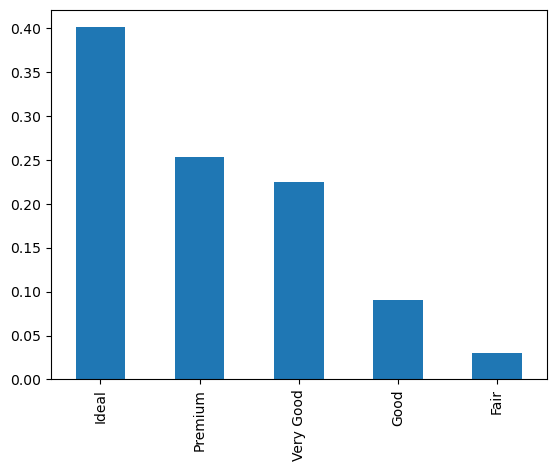

In [51]:
proportions_cut.plot.bar()

---

* Color

In [52]:
proportions_color = diamondsdf['color'].value_counts(normalize= True)
proportions_color

G    0.208932
E    0.181137
F    0.177378
H    0.155098
D    0.124855
I    0.099681
J    0.052919
Name: color, dtype: float64

* Plot of color

<Axes: >

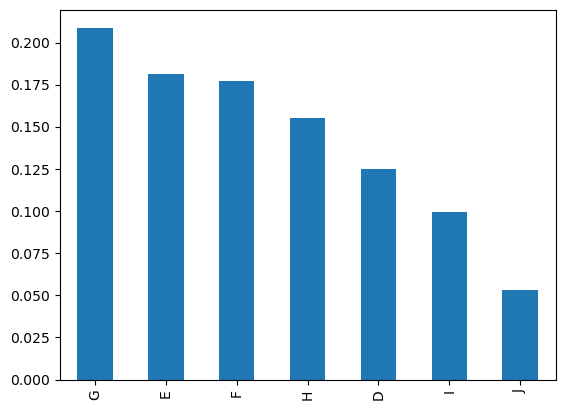

In [53]:
proportions_color.plot.bar()

* Clarity

In [54]:
proportions_clarity = diamondsdf['clarity'].value_counts(normalize= True)
proportions_clarity

SI1     0.241030
VS2     0.228641
SI2     0.171122
VS1     0.149979
VVS2    0.093944
VVS1    0.068597
IF      0.032815
I1      0.013873
Name: clarity, dtype: float64

* Plot of clarity

<Axes: >

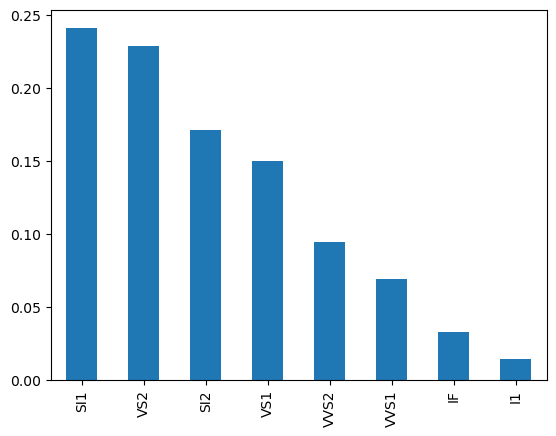

In [55]:
proportions_clarity.plot.bar()

* City

In [56]:
proportions_city = diamondsdf['city'].value_counts(normalize= True)
proportions_city

Surat            0.125399
Antwerp          0.124781
Kimberly         0.122951
Luxembourg       0.064443
Las Vegas        0.063948
New York City    0.063899
Dubai            0.063305
Madrid           0.062736
Paris            0.062539
Tel Aviv         0.061920
Zurich           0.061747
Amsterdam        0.061451
London           0.060882
Name: city, dtype: float64

* Plot of city

<Axes: >

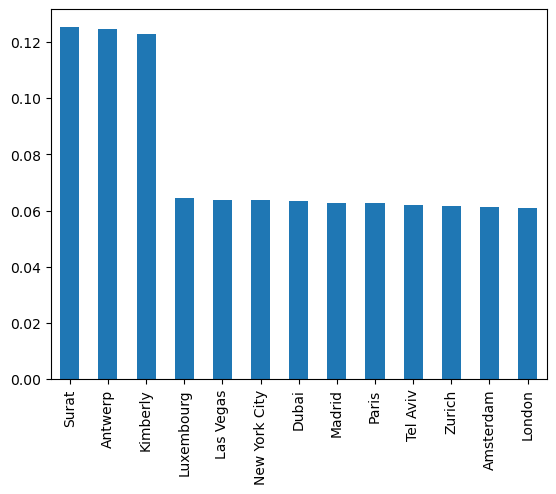

In [57]:
proportions_city.plot.bar()

---

## Color describe

In [58]:
diamondsdf['color'].unique()

array(['H', 'J', 'I', 'G', 'D', 'E', 'F'], dtype=object)

* Color J

In [59]:
diamondsdfcolorJ = diamondsdf[diamondsdf['color'].str.contains('J')].sort_values(by = 'price', ascending = False)
diamondsdfcolorJ.describe()

price        carat        depth        table            x  \
count   2140.000000  2140.000000  2140.000000  2140.000000  2140.000000   
mean    5346.234112     1.166500    61.909626    57.790701     6.527285   
std     4437.967123     0.595036     1.564846     2.292664     1.204126   
min      335.000000     0.230000    43.000000    52.000000     3.930000   
25%     1859.000000     0.710000    61.200000    56.000000     5.710000   
50%     4268.500000     1.120000    62.000000    58.000000     6.660000   
75%     7751.750000     1.520000    62.700000    59.000000     7.380000   
max    18710.000000     4.500000    73.600000    68.000000    10.230000   

                 y            z  price/carat  price/depth  price/table  ...  \
count  2140.000000  2140.000000  2140.000000  2140.000000  2140.000000  ...   
mean      6.525570     4.039879  3827.670485    86.503086    92.261659  ...   
std       1.197141     0.741925  1640.653644    71.969993    76.481938  ...   
min       3.900000     2.460000  1080.645161     5.292259     5.775862  ...   
25%       5.730000     3.530000  2562.950980    30.125840    31.966481  ...   
50%       6.660000     4.120000  3780.392157    68.795056    74.833680  ...   
75%       7.390000     4.580000  4942.531250   125.370311   132.430085  ...   
max      10.160000     6.720000  8547.222222   317.211704   335.672727  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2140.000000  2140.000000  2140.000000  2140.000000  2140.000000   
mean     74.034312    14.826001    68.761542     0.271296     1.615878   
std      49.134506     2.953811    45.013426     0.096287     0.039777   
min      14.622222     8.630952    12.888889     0.093496     1.381609   
25%      40.259321    12.645697    37.908497     0.201117     1.594353   
50%      54.823009    14.039409    50.917508     0.272837     1.611604   
75%      87.083333    16.571429    81.690141     0.336308     1.633153   
max     273.043478    24.015748   243.478261     0.669643     1.839763   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2140.000000  2140.000000  2140.000000  2140.000000  2140.000000  
mean      1.615819     1.000088     3.059659     3.268840   162.629286  
std       0.040315     0.008991     1.555506     1.647834     5.844813  
min       1.333333     0.974125     0.600389     0.673293   146.932830  
25%       1.594365     0.993072     1.869982     1.990562   160.800324  
50%       1.614455     0.996433     2.957918     3.211860   162.624415  
75%       1.634905     1.007299     4.017265     4.277611   164.588222  
max       1.812500     1.046075    10.614822    12.042333   322.529040  

[8 rows x 25 columns]

* Color H

In [60]:
diamondsdfcolorH = diamondsdf[diamondsdf['color'].str.contains('H')].sort_values(by = 'price', ascending = False)
diamondsdfcolorH.describe()

price        carat        depth        table            x  \
count   6272.000000  6272.000000  6272.000000  6272.000000  6272.000000   
mean    4468.987883     0.909541    61.828268    57.532972     5.981162   
std     4194.236021     0.519316     1.457297     2.257802     1.193522   
min      337.000000     0.230000    52.700000    50.000000     3.890000   
25%      984.000000     0.410000    61.100000    56.000000     4.790000   
50%     3447.000000     0.900000    61.900000    57.000000     6.150000   
75%     5945.000000     1.200000    62.600000    59.000000     6.810000   
max    18795.000000     4.130000    71.800000    73.000000    10.000000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  6272.000000  6272.000000   6272.000000  6272.000000  6272.000000  ...   
mean      5.983850     3.696574   4004.147569    72.370154    77.371754  ...   
std       1.356538     0.736900   1839.805072    68.060727    72.426815  ...   
min       3.900000     2.380000   1051.162791     5.444265     5.540984  ...   
25%       4.790000     2.960000   2394.678382    15.919020    17.139161  ...   
50%       6.140000     3.820000   3807.549858    55.647911    59.465517  ...   
75%       6.790000     4.210000   5114.851485    96.307779   104.099633  ...   
max      58.900000     8.060000  10187.500000   323.493976   354.615385  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  6272.000000  6272.000000  6272.000000  6272.000000  6272.000000   
mean     97.870595    16.195499    90.627706     0.228464     1.618388   
std      60.884454     3.286847    55.762078     0.089560     0.040610   
min      15.690073     7.071960    14.769976     0.087838     1.003722   
25%      51.570248    13.626106    47.933884     0.139456     1.596774   
50%      69.061050    15.384615    64.583333     0.235218     1.614795   
75%     149.756098    19.112628   136.585366     0.285466     1.636877   
max     277.826087    26.016260   265.217391     0.642302     2.028424   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  6272.000000  6272.000000  6272.000000  6272.000000  6272.000000  
mean      1.618587     1.000469     2.400638     2.571249   163.287217  
std       0.082417     0.018501     1.571808     1.657041    22.570983  
min       1.110811     0.137351     0.591170     0.630505    88.148344  
25%       1.596695     0.993056     1.098803     1.201456   161.204394  
50%       1.616402     0.997335     2.321790     2.474428   163.207872  
75%       1.638185     1.007474     3.151626     3.382456   165.172857  
max       7.307692     1.615572    65.205400    67.378913  1920.299030  

[8 rows x 25 columns]

* Color D

In [61]:
diamondsdfcolorD = diamondsdf[diamondsdf['color'].str.contains('D')].sort_values(by = 'price', ascending = False)
diamondsdfcolorD.describe()

price        carat        depth        table            x  \
count   5049.000000  5049.000000  5049.000000  5049.000000  5049.000000   
mean    3134.943157     0.653036    61.721886    57.344959     5.404704   
std     3315.698012     0.356574     1.399186     2.197308     0.933477   
min      357.000000     0.200000    54.200000    52.000000     3.770000   
25%      898.000000     0.360000    61.000000    56.000000     4.570000   
50%     1820.000000     0.530000    61.800000    57.000000     5.220000   
75%     4183.000000     0.900000    62.500000    59.000000     6.160000   
max    18693.000000     3.400000    71.600000    73.000000     9.420000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  5049.000000  5049.000000   5049.000000  5049.000000  5049.000000  ...   
mean      5.409541     3.336782   3937.805478    50.838051    54.426669  ...   
std       0.930675     0.575823   2088.646746    53.813146    57.421143  ...   
min       3.720000     2.290000   1128.125000     5.640625     5.852459  ...   
25%       4.570000     2.810000   2442.500000    14.515599    15.614035  ...   
50%       5.230000     3.220000   3383.516484    29.478827    32.087719  ...   
75%       6.170000     3.830000   4731.428571    67.516026    72.300000  ...   
max       9.340000     6.270000  17828.846154   306.463621   333.054545  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  5049.000000  5049.000000  5049.000000  5049.000000  5049.000000   
mean    121.836228    17.658365   112.791051     0.184450     1.620139   
std      56.808321     2.864134    52.216603     0.066068     0.037430   
min      19.647059     8.293461    15.294118     0.085837     1.420779   
25%      68.586957    15.320334    64.444444     0.126761     1.597484   
50%     115.471698    17.595308   105.769231     0.165644     1.616541   
75%     173.142857    20.072993   160.000000     0.236364     1.638821   
max     308.500000    27.848101   300.000000     0.542265     1.851406   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  5049.000000  5049.000000  5049.000000  5049.000000  5049.000000  
mean      1.621768     0.999040     1.726488     1.851460   163.539263  
std       0.037818     0.008687     0.936152     0.987894     3.053898  
min       1.371429     0.964912     0.525063     0.539939   143.439320  
25%       1.599440     0.992381     0.954212     1.034415   161.861463  
50%       1.619403     0.995495     1.426447     1.548592   163.744425  
75%       1.641270     1.006881     2.344983     2.493661   165.469733  
max       1.848993     1.057915     8.258266    10.608695   198.968946  

[8 rows x 25 columns]

* Color G

In [62]:
diamondsdfcolorG = diamondsdf[diamondsdf['color'].str.contains('G')].sort_values(by = 'price', ascending = False)
diamondsdfcolorG.describe()

price        carat        depth        table            x  \
count   8449.000000  8449.000000  8449.000000  8449.000000  8449.000000   
mean    4021.065215     0.773903    61.753249    57.285963     5.683880   
std     4062.078668     0.444850     1.377532     2.130708     1.085142   
min      354.000000     0.230000    43.000000    52.000000     3.870000   
25%      934.000000     0.390000    61.100000    56.000000     4.690000   
50%     2258.000000     0.700000    61.800000    57.000000     5.650000   
75%     6108.000000     1.040000    62.500000    59.000000     6.530000   
max    18818.000000     3.010000    72.900000    76.000000     9.440000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  8449.000000  8449.000000   8449.000000  8449.000000  8449.000000  ...   
mean      5.687000     3.511348   4171.345629    65.162241    70.009524  ...   
std       1.077319     0.671504   2146.839324    65.925667    70.676864  ...   
min       3.900000     2.340000   1139.024390     5.794543     5.590909  ...   
25%       4.700000     2.890000   2533.333333    15.106383    16.500000  ...   
50%       5.640000     3.490000   3492.156863    36.327869    39.203390  ...   
75%       6.530000     4.030000   5599.009901    98.651685   105.491803  ...   
max       9.370000     6.160000  12460.666667   313.010033   347.981481  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  8449.000000  8449.000000  8449.000000  8449.000000  8449.000000   
mean    109.582725    16.895316   101.352467     0.205423     1.619239   
std      58.934142     3.146596    54.114788     0.079236     0.036524   
min      19.867110     9.090909    19.269103     0.080128     0.990119   
25%      58.910891    14.180929    54.807692     0.134483     1.599327   
50%      89.714286    16.616314    84.507042     0.197222     1.616099   
75%     158.157895    19.780220   147.368421     0.260309     1.636704   
max     277.391304    27.615063   286.956522     0.535587     1.841499   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  8449.000000  8449.000000  8449.000000  8449.000000  8449.000000  
mean      1.620586     0.999225     2.041931     2.196323   163.421312  
std       0.037577     0.008904     1.165115     1.242852     4.334476  
min       0.996047     0.963899     0.589003     0.547951    91.300440  
25%       1.600559     0.992647     1.032253     1.114783   161.691681  
50%       1.619748     0.995601     1.802721     1.910490   163.580681  
75%       1.639594     1.006834     2.782999     2.986015   165.416332  
max       1.810417     1.118976     8.312788     8.570771   351.217152  

[8 rows x 25 columns]

* Color F

In [63]:
diamondsdfcolorF = diamondsdf[diamondsdf['color'].str.contains('F')].sort_values(by = 'price', ascending = False)
diamondsdfcolorF.describe()

price        carat        depth        table            x  \
count   7173.000000  7173.000000  7173.000000  7173.000000  7173.000000   
mean    3677.586923     0.731423    61.689642    57.409118     5.603611   
std     3772.338588     0.396697     1.435325     2.264932     1.001142   
min      342.000000     0.220000    52.300000    50.000000     3.830000   
25%      975.000000     0.400000    61.000000    56.000000     4.720000   
50%     2312.000000     0.700000    61.800000    57.000000     5.620000   
75%     4759.000000     1.010000    62.500000    59.000000     6.400000   
max    18791.000000     3.010000    71.000000    95.000000     9.240000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  7173.000000  7173.000000   7173.000000  7173.000000  7173.000000  ...   
mean      5.608556     3.457857   4106.602429    59.640725    63.911815  ...   
std       0.993864     0.620388   2127.196956    61.282484    65.471569  ...   
min       3.840000     1.070000   1168.000000     5.595611     5.606557  ...   
25%       4.730000     2.910000   2586.666667    15.751212    17.052632  ...   
50%       5.620000     3.460000   3462.000000    37.508091    40.000000  ...   
75%       6.410000     3.970000   4938.834951    76.786834    82.379310  ...   
max       9.130000     5.730000  13860.902256   323.989637   338.909091  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  7173.000000  7173.000000  7173.000000  7173.000000  7173.000000   
mean    111.805028    17.126617   103.770880     0.198860     1.621621   
std      58.276645     3.057533    53.761239     0.072575     0.066187   
min      20.664452     9.773124    18.604651     0.092050     1.419525   
25%      61.584158    14.609572    57.692308     0.136213     1.600000   
50%      90.142857    16.816817    87.142857     0.196629     1.617169   
75%     155.000000    19.655172   143.684211     0.253769     1.638298   
max     280.454545    53.271028   286.956522     1.000000     6.186916   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  7173.000000  7173.000000  7173.000000  7173.000000  7173.000000  
mean      1.623498     0.998905     1.932197     2.072484   163.463117  
std       0.067200     0.009200     1.039703     1.105600     3.518190  
min       1.396501     0.832258     0.568431     0.561204    44.155400  
25%       1.601504     0.992352     1.055252     1.141009   161.638400  
50%       1.620438     0.995444     1.775969     1.873400   163.707012  
75%       1.641753     1.006711     2.622230     2.800867   165.510856  
max       6.233645     1.053782     7.771538     8.631959   196.177358  

[8 rows x 25 columns]

* Color E

In [64]:
diamondsdfcolorE = diamondsdf[diamondsdf['color'].str.contains('E')].sort_values(by = 'price', ascending = False)
diamondsdfcolorE.describe()

price        carat        depth        table            x  \
count   7325.000000  7325.000000  7325.000000  7325.000000  7325.000000   
mean    3088.342526     0.658835    61.659836    57.494567     5.413894   
std     3354.545963     0.368947     1.417519     2.235462     0.963119   
min      326.000000     0.200000    53.300000    44.000000     3.790000   
25%      882.000000     0.360000    60.900000    56.000000     4.570000   
50%     1735.000000     0.530000    61.800000    57.000000     5.230000   
75%     4026.000000     0.910000    62.500000    59.000000     6.190000   
max    18731.000000     3.050000    79.000000    73.000000     9.260000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  7325.000000  7325.000000   7325.000000  7325.000000  7325.000000  ...   
mean      5.418651     3.338709   3810.101878    50.134624    53.544492  ...   
std       0.958256     0.593599   1946.815305    54.601808    57.949345  ...   
min       3.750000     2.060000   1290.697674     5.176651     5.030769  ...   
25%       4.580000     2.810000   2416.129032    14.354067    15.578947  ...   
50%       5.240000     3.220000   3257.692308    28.225256    30.327273  ...   
75%       6.190000     3.840000   4529.870130    65.040258    68.473684  ...   
max       9.250000     5.660000  14609.375000   313.227425   331.375000  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  7325.000000  7325.000000  7325.000000  7325.000000  7325.000000   
mean    122.511484    17.734027   113.957745     0.185376     1.622059   
std      59.329297     3.022378    55.078752     0.068182     0.041050   
min      19.967213    10.247350    19.016393     0.086957     1.273839   
25%      68.111111    15.245478    63.736264     0.127208     1.599237   
50%     114.727273    17.613636   105.769231     0.166667     1.617722   
75%     171.666667    20.143885   159.459459     0.237467     1.640152   
max     301.000000    28.138528   310.000000     0.538869     2.518939   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  7325.000000  7325.000000  7325.000000  7325.000000  7325.000000  
mean      1.623763     0.998991     1.743610     1.865215   163.550825  
std       0.040061     0.010233     0.970677     1.024605     3.300764  
min       1.266504     0.967001     0.535920     0.520361   115.999364  
25%       1.601246     0.992343     0.954418     1.031351   161.811650  
50%       1.620915     0.995465     1.429992     1.548142   163.651150  
75%       1.642857     1.006787     2.373396     2.526041   165.502695  
max       2.373333     1.442516     7.960711     8.358747   238.038706  

[8 rows x 25 columns]

* Color I

In [65]:
diamondsdfcolorI = diamondsdf[diamondsdf['color'].str.contains('I')].sort_values(by = 'price', ascending = False)
diamondsdfcolorI.describe()

price        carat        depth        table            x  \
count   4031.000000  4031.000000  4031.000000  4031.000000  4031.000000   
mean    5088.312081     1.026487    61.873356    57.562466     6.215527   
std     4765.938121     0.585643     1.464037     2.318643     1.267422   
min      334.000000     0.230000    55.300000    43.000000     3.940000   
25%     1088.500000     0.510000    61.200000    56.000000     5.120000   
50%     3709.000000     1.000000    62.000000    57.000000     6.340000   
75%     7207.000000     1.500000    62.600000    59.000000     7.205000   
max    18823.000000     4.010000    71.300000    70.000000    10.140000   

                 y            z  price/carat  price/depth  price/table  ...  \
count  4031.000000  4031.000000  4031.000000  4031.000000  4031.000000  ...   
mean      6.215128     3.843032  3980.126032    82.463879    87.879960  ...   
std       1.256870     0.776521  1896.831448    77.575869    81.893667  ...   
min       3.900000     1.530000  1151.724138     5.352564     5.758621  ...   
25%       5.125000     3.160000  2283.809524    17.567568    19.265664  ...   
50%       6.340000     3.930000  3746.478873    60.128824    63.258621  ...   
75%       7.190000     4.450000  5152.148148   115.748616   124.479112  ...   
max      10.100000     6.310000  9397.500000   325.852373   341.436364  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  4031.000000  4031.000000  4031.000000  4031.000000  4031.000000   
mean     88.590889    15.613857    81.878914     0.247663     1.617652   
std      58.194195     3.267894    53.113119     0.098765     0.064024   
min      15.211970     9.191759    14.500000     0.093117     1.406571   
25%      42.416543    13.100437    40.634085     0.160249     1.595712   
50%      62.900000    14.796954    58.947368     0.250620     1.612903   
75%     122.134238    18.017839   111.764706     0.326134     1.634619   
max     273.913043    35.294118   243.478261     1.000000     4.856209   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  4031.000000  4031.000000  4031.000000  4031.000000  4031.000000  
mean      1.618143     0.999755     2.697641     2.884555   162.808302  
std       0.065069     0.008984     1.539768     1.620428     3.580332  
min       1.384439     0.969784     0.602445     0.677750    55.725000  
25%       1.596676     0.992898     1.337833     1.470227   161.075394  
50%       1.615599     0.996071     2.564743     2.708518   163.071262  
75%       1.636620     1.007009     3.723273     3.953822   164.904002  
max       4.901961     1.085950    10.358924    10.824849   184.701041  

[8 rows x 25 columns]

---

## Clarity describe

In [66]:
diamondsdf['clarity'].unique()

array(['SI2', 'I1', 'VS2', 'SI1', 'VS1', 'IF', 'VVS1', 'VVS2'],
      dtype=object)

* Clarity VS2

In [67]:
diamondsdf_clarity_VS2 = diamondsdf[diamondsdf['clarity'].str.contains('VS2')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_VS2.describe()

price         carat         depth         table             x  \
count  13045.000000  13045.000000  13045.000000  13045.000000  13045.000000   
mean    3716.488310      0.712770     61.703273     57.296351      5.524645   
std     3972.490889      0.428767      1.293683      2.143932      1.072441   
min      334.000000      0.200000     43.000000     51.000000      3.770000   
25%      847.000000      0.350000     61.100000     56.000000      4.530000   
50%     1882.000000      0.550000     61.800000     57.000000      5.280000   
75%     5774.000000      1.010000     62.400000     59.000000      6.420000   
max    18823.000000      3.510000     79.000000     73.000000      9.660000   

                  y             z   price/carat   price/depth   price/table  \
count  13045.000000  13045.000000  13045.000000  13045.000000  13045.000000   
mean       5.529473      3.409891   4104.496925     60.267533     64.620221   
std        1.067349      0.661201   2162.988973     64.490429     68.852774   
min        3.720000      2.060000   1151.724138      5.176651      5.524590   
25%        4.540000      2.790000   2436.585366     13.769100     14.946429   
50%        5.290000      3.250000   3364.705882     30.635179     33.072727   
75%        6.420000      3.980000   5344.285714     93.203252     99.389831   
max        9.630000      6.030000  13441.666667    321.124567    341.436364   

       ...   depth/carat       table/z   table/carat       carat/z  \
count  ...  13045.000000  13045.000000  13045.000000  13045.000000   
mean   ...    118.972862     17.401007    110.180153      0.194173   
std    ...     61.530709      3.206036     56.803014      0.077412   
min    ...     17.806268      9.784411     16.809117      0.085837   
25%    ...     61.287129     14.572864     57.425743      0.124555   
50%    ...    111.818182     17.378049    103.448276      0.169279   
75%    ...    176.857143     20.209059    162.857143      0.254408   
max    ...    308.500000     27.615063    310.000000      0.582090   

                x/z           y/z           x/y     xyz/depth     xyz/table  \
count  13045.000000  13045.000000  13045.000000  13045.000000  13045.000000   
mean       1.620544      1.622280      0.998978      1.884655      2.023951   
std        0.036361      0.035840      0.010531      1.127286      1.195432   
min        1.273839      1.175000      0.832258      0.525063      0.520832   
25%        1.600000      1.602190      0.992481      0.930694      1.010570   
50%        1.616438      1.619718      0.995506      1.472689      1.600435   
75%        1.636637      1.639405      1.006757      2.646778      2.829159   
max        2.518939      2.373333      1.506383      8.975129      9.507552   

          xyz/carat  
count  13045.000000  
mean     163.561804  
std        3.456731  
min       88.148344  
25%      161.867531  
50%      163.686549  
75%      165.443453  
max      322.101960  

[8 rows x 25 columns]

* Clarity VS1

In [68]:
diamondsdf_clarity_VS1 = diamondsdf[diamondsdf['clarity'].str.contains('VS1')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_VS1.describe()

price        carat        depth        table            x  \
count   8839.000000  8839.000000  8839.000000  8839.000000  8839.000000   
mean    3408.206698     0.654169    61.656816    57.172689     5.373449   
std     3847.867839     0.401453     1.230207     2.173739     1.034191   
min      327.000000     0.230000    54.000000    43.000000     3.830000   
25%      840.000000     0.330000    61.100000    56.000000     4.460000   
50%     1680.000000     0.510000    61.800000    57.000000     5.130000   
75%     4455.000000     0.900000    62.300000    58.000000     6.160000   
max    18795.000000     2.590000    71.800000    73.000000     8.830000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  8839.000000  8839.000000   8839.000000  8839.000000  8839.000000  ...   
mean      5.383193     3.315828   4051.699967    55.323594    59.422834  ...   
std       1.030043     0.637226   2205.844728    62.578099    66.890976  ...   
min       3.850000     2.310000   1214.705882     5.414013     5.030769  ...   
25%       4.470000     2.750000   2455.000000    13.635616    14.828896  ...   
50%       5.140000     3.170000   3277.464789    27.246127    29.428571  ...   
75%       6.170000     3.840000   5042.692308    71.451959    77.643579  ...   
max       8.770000     5.430000  14498.000000   318.402778   335.672727  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  8839.000000  8839.000000  8839.000000  8839.000000  8839.000000   
mean    127.631514    17.829617   118.128656     0.183303     1.620864   
std      61.635588     3.184479    57.045524     0.073541     0.034214   
min      23.822394    10.266160    21.621622     0.092000     0.990119   
25%      69.000000    15.143603    63.736264     0.120438     1.601732   
50%     121.000000    18.151815   111.764706     0.160883     1.617100   
75%     186.363636    20.437956   169.696970     0.235602     1.636029   
max     280.000000    28.138528   286.956522     0.476980     2.028424   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  8839.000000  8839.000000  8839.000000  8839.000000  8839.000000  
mean      1.624126     0.998057     1.735209     1.867371   163.938267  
std       0.034714     0.011382     1.059007     1.127018     3.963414  
min       0.996047     0.964486     0.565896     0.554598    90.155786  
25%       1.605469     0.992248     0.887669     0.970727   162.218288  
50%       1.621681     0.995025     1.355062     1.464395   163.957632  
75%       1.640227     1.005922     2.337409     2.511969   165.783267  
max       1.844961     1.615572     6.815143     7.508827   322.529040  

[8 rows x 25 columns]

* Clarity SI1

In [69]:
diamondsdf_clarity_SI1 = diamondsdf[diamondsdf['clarity'].str.contains('SI1')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_SI1.describe()

price        carat        depth        table            x  \
count   9747.000000  9747.000000  9747.000000  9747.000000  9747.000000   
mean    3997.326665     0.850893    61.859793    57.648374     5.888074   
std     3817.529619     0.451393     1.473718     2.255230     1.047716   
min      326.000000     0.210000    43.000000    49.000000     3.880000   
25%     1082.000000     0.500000    61.100000    56.000000     5.040000   
50%     2821.000000     0.760000    62.000000    57.000000     5.870000   
75%     5255.000000     1.060000    62.800000    59.000000     6.570000   
max    18818.000000     2.570000    72.900000    95.000000     8.900000   

                 y            z  price/carat  price/depth  price/table  ...  \
count  9747.000000  9747.000000  9747.000000  9747.000000  9747.000000  ...   
mean      5.887755     3.640737  3843.938943    64.716610    69.142873  ...   
std       1.041800     0.645574  1760.896763    61.981773    65.868533  ...   
min       3.840000     1.070000  1130.000000     5.296875     5.344262  ...   
25%       5.030000     3.110000  2361.764706    17.375626    18.781746  ...   
50%       5.870000     3.630000  3666.071429    45.607780    49.333333  ...   
75%       6.570000     4.060000  4927.777778    85.299811    90.716667  ...   
max       8.870000     5.490000  9692.982456   325.852373   354.615385  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  9747.000000  9747.000000  9747.000000  9747.000000  9747.000000   
mean     96.566477    16.332561    89.667855     0.220093     1.618056   
std      52.308268     2.939269    48.025936     0.079277     0.068908   
min      23.214286     9.796673    21.686747     0.090909     1.278008   
25%      57.663551    14.081146    53.846154     0.156740     1.592978   
50%      80.886076    15.819209    75.000000     0.210811     1.613208   
75%     126.400000    18.611987   119.607843     0.263959     1.637210   
max     284.761905    53.271028   290.476190     1.000000     6.186916   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  9747.000000  9747.000000  9747.000000  9747.000000  9747.000000  
mean      1.618259     0.999928     2.236453     2.394214   162.829418  
std       0.069721     0.009095     1.184681     1.256050     3.695194  
min       1.275934     0.935421     0.574754     0.565670    44.155400  
25%       1.593284     0.992908     1.280029     1.354962   161.067436  
50%       1.614887     0.996510     2.021006     2.181425   163.066065  
75%       1.638686     1.007310     2.837403     3.030729   164.968022  
max       6.233645     1.118976     7.017156     7.549461   184.701041  

[8 rows x 25 columns]

* Clarity IF

In [70]:
diamondsdf_clarity_IF = diamondsdf[diamondsdf['clarity'].str.contains('IF')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_IF.describe()

price        carat        depth        table            x  \
count   1327.000000  1327.000000  1327.000000  1327.000000  1327.000000   
mean    2797.897513     0.499849    61.511454    56.496684     4.953451   
std     3834.632644     0.308331     1.039907     1.964524     0.854171   
min      369.000000     0.230000    52.300000    52.800000     3.890000   
25%      894.000000     0.310000    61.000000    55.000000     4.370000   
50%     1080.000000     0.350000    61.700000    56.000000     4.560000   
75%     2315.500000     0.540000    62.100000    58.000000     5.260000   
max    18806.000000     2.290000    65.600000    65.000000     8.490000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  1327.000000  1327.000000   1327.000000  1327.000000  1327.000000  ...   
mean      4.975011     3.052427   4217.324475    45.534385    49.067806  ...   
std       0.855255     0.523473   2671.363614    62.455357    66.802082  ...   
min       3.900000     2.390000   1587.804878     5.774648     6.709091  ...   
25%       4.390000     2.700000   2865.686275    14.529073    16.109091  ...   
50%       4.570000     2.800000   3151.612903    17.677100    19.127273  ...   
75%       5.300000     3.235000   4236.111111    37.808031    41.157895  ...   
max       8.450000     5.200000  17828.846154   308.072488   341.927273  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  1327.000000  1327.000000  1327.000000  1327.000000  1327.000000   
mean    154.173506    18.946951   141.148977     0.153757     1.622819   
std      55.577390     2.672877    50.474701     0.058749     0.028515   
min      26.812227    11.373391    26.200873     0.092369     1.513678   
25%     112.830189    17.445483   103.773585     0.115528     1.605911   
50%     174.705882    19.780220   158.823529     0.125000     1.618519   
75%     197.741935    20.817844   180.322581     0.167692     1.635333   
max     277.826087    26.104418   269.565217     0.440385     1.922481   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  1327.000000  1327.000000  1327.000000  1327.000000  1327.000000  
mean      1.629991     0.995631     1.340641     1.452957   165.311241  
std       0.029136     0.007158     0.819732     0.869552     2.718130  
min       1.531008     0.975052     0.591170     0.615168   153.677086  
25%       1.613636     0.991247     0.840864     0.926680   163.595050  
50%       1.626168     0.993478     0.951550     1.047118   165.312000  
75%       1.642201     0.996409     1.472472     1.591595   167.137416  
max       1.903101     1.027586     6.075743     6.217510   176.006387  

[8 rows x 25 columns]

* Clarity VVS1

In [71]:
diamondsdf_clarity_VVS1 = diamondsdf[diamondsdf['clarity'].str.contains('VVS1')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_VVS1.describe()

price        carat        depth        table            x  \
count   2774.000000  2774.000000  2774.000000  2774.000000  2774.000000   
mean    2559.498558     0.506994    61.606921    56.929740     4.973554   
std     3333.512733     0.300918     1.083490     2.050183     0.848642   
min      395.000000     0.230000    54.000000    52.000000     3.870000   
25%      816.000000     0.310000    61.100000    56.000000     4.360000   
50%     1097.000000     0.400000    61.700000    57.000000     4.710000   
75%     2513.750000     0.570000    62.300000    58.000000     5.340000   
max    18777.000000     2.160000    66.100000    68.000000     8.360000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  2774.000000  2774.000000   2774.000000  2774.000000  2774.000000  ...   
mean      4.988504     3.068893   3882.807337    41.578100    44.880705  ...   
std       0.848811     0.524929   2241.857694    54.277345    58.298115  ...   
min       3.900000     2.340000   1487.096774     6.571429     6.265625  ...   
25%       4.380000     2.690000   2545.161290    13.270105    14.535714  ...   
50%       4.720000     2.900000   3000.000000    17.896461    19.332846  ...   
75%       5.350000     3.290000   4140.288462    40.615479    43.369397  ...   
max       8.260000     5.110000  14498.000000   307.269737   333.607143  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2774.000000  2774.000000  2774.000000  2774.000000  2774.000000   
mean    152.507137    19.024236   140.937915     0.155451     1.621087   
std      58.683627     2.916838    54.891545     0.057764     0.031921   
min      28.472222    11.350294    26.851852     0.092000     0.990119   
25%     107.640653    17.049643    98.245614     0.115672     1.603741   
50%     156.341463    19.587629   146.049896     0.135135     1.618017   
75%     198.387097    21.033210   181.250000     0.173344     1.634409   
max     280.000000    27.848101   286.956522     0.422701     1.860465   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2774.000000  2774.000000  2774.000000  2774.000000  2774.000000  
mean      1.626074     0.996965     1.351026     1.461339   164.485292  
std       0.032190     0.007709     0.796322     0.853524     3.166896  
min       0.996047     0.964486     0.585908     0.554598   151.783703  
25%       1.609056     0.992278     0.834508     0.908763   162.758750  
50%       1.623529     0.994511     1.048097     1.124528   164.428258  
75%       1.640208     1.004211     1.531978     1.674529   166.254975  
max       1.844961     1.036822     5.737624     6.083860   255.534048  

[8 rows x 25 columns]

* Clarity VVS2

In [72]:
diamondsdf_clarity_VVS2 = diamondsdf[diamondsdf['clarity'].str.contains('VVS2')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_VVS2.describe()

price        carat        depth        table            x  \
count   3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean    3240.978942     0.591777    61.658884    57.031561     5.206976   
std     3794.536518     0.356620     1.145401     2.071003     0.973559   
min      354.000000     0.230000    54.200000    52.000000     3.830000   
25%      791.000000     0.320000    61.100000    56.000000     4.390000   
50%     1289.000000     0.430000    61.700000    57.000000     4.870000   
75%     3482.000000     0.730000    62.300000    58.000000     5.800000   
max    18718.000000     2.070000    67.000000    68.000000     8.180000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  3799.000000  3799.000000   3799.000000  3799.000000  3799.000000  ...   
mean      5.220753     3.213917   4178.017868    52.585919    56.769786  ...   
std       0.971871     0.600665   2426.625046    61.541409    66.437803  ...   
min       3.860000     2.060000   1339.285714     5.860927     5.590909  ...   
25%       4.400000     2.710000   2452.916667    12.829268    14.053571  ...   
50%       4.880000     3.000000   3167.741935    20.807249    22.509091  ...   
75%       5.820000     3.580000   4848.263889    57.032134    61.438437  ...   
max       8.140000     5.110000  13441.666667   313.010033   334.127273  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean    138.428656    18.317711   127.965212     0.171672     1.620398   
std      64.005920     3.194117    59.492744     0.067205     0.032912   
min      30.289855    10.567515    26.086957     0.092000     1.494585   
25%      84.246575    15.819209    77.084942     0.117216     1.602236   
50%     142.558140    18.728522   130.952381     0.144295     1.617128   
75%     194.062500    20.802920   178.125000     0.204545     1.634808   
max     280.434783    27.615063   286.956522     0.406000     2.286408   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000  
mean      1.624927     0.997252     1.572048     1.698708   164.114048  
std       0.033185     0.008514     0.940119     1.011616     2.809352  
min       1.483461     0.832258     0.568431     0.547951   119.495179  
25%       1.607454     0.992154     0.851956     0.928066   162.515428  
50%       1.622490     0.994495     1.158983     1.259335   164.140378  
75%       1.640000     1.004592     1.956286     2.132500   165.851368  
max       2.271845     1.034735     5.406690     6.277767   196.177358  

[8 rows x 25 columns]

* Clarity I1

In [73]:
diamondsdf_clarity_I1 = diamondsdf[diamondsdf['clarity'].str.contains('I1')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_I1.describe()

price         carat         depth         table             x  \
count  10308.000000  10308.000000  10308.000000  10308.000000  10308.000000   
mean    3995.909391      0.875321     61.911564     57.680093      5.936743   
std     3769.502484      0.474388      1.590683      2.277241      1.067356   
min      326.000000      0.210000     43.000000     49.000000      3.880000   
25%     1134.000000      0.500000     61.100000     56.000000      5.070000   
50%     2863.000000      0.800000     62.000000     57.000000      5.950000   
75%     5255.000000      1.090000     62.800000     59.000000      6.620000   
max    18818.000000      4.500000     73.600000     95.000000     10.230000   

                  y             z   price/carat   price/depth   price/table  \
count  10308.000000  10308.000000  10308.000000  10308.000000  10308.000000   
mean       5.933548      3.673481   3786.950770     64.643629     69.104320   
std        1.059690      0.661467   1740.111146     61.168434     65.045047   
min        3.840000      1.070000   1051.162791      5.296875      5.344262   
25%        5.070000      3.150000   2361.290323     18.250108     19.682801   
50%        5.950000      3.680000   3542.555332     46.350475     50.061171   
75%        6.610000      4.080000   4859.055825     85.186347     90.688095   
max       10.160000      6.720000   9692.982456    325.852373    354.615385   

       ...   depth/carat       table/z   table/carat       carat/z  \
count  ...  10308.000000  10308.000000  10308.000000  10308.000000   
mean   ...     94.605592     16.210437     87.845061      0.224013   
std    ...     52.074063      2.957780     47.834279      0.081729   
min    ...     14.622222      8.293461     12.888889      0.090909   
25%    ...     56.529430     13.998728     52.777778      0.158730   
50%    ...     77.609968     15.702479     71.794872      0.216438   
75%    ...    124.200000     18.471338    115.764706      0.267640   
max    ...    284.761905     53.271028    290.476190      1.000000   

                x/z           y/z           x/y     xyz/depth     xyz/table  \
count  10308.000000  10308.000000  10308.000000  10308.000000  10308.000000   
mean       1.617137      1.616637      1.000378      2.294976      2.458583   
std        0.069045      0.070229      0.009397      1.235190      1.314644   
min        1.278008      1.275934      0.935421      0.574754      0.565670   
25%        1.592402      1.592105      0.993023      1.310583      1.403445   
50%        1.612999      1.614325      0.997399      2.103819      2.255053   
75%        1.637224      1.638351      1.007611      2.896359      3.094510   
max        6.186916      6.233645      1.118976     10.614822     12.042333   

          xyz/carat  
count  10308.000000  
mean     162.688818  
std        3.787187  
min       44.155400  
25%      160.924557  
50%      162.975765  
75%      164.910754  
max      187.999194  

[8 rows x 25 columns]

---

## Cut describe

In [74]:
diamondsdf['cut'].unique()

array(['Premium', 'Fair', 'Very Good', 'Ideal', 'Good'], dtype=object)

* Premiun

In [75]:
diamondsdf_cut_Premium = diamondsdf[diamondsdf['cut'].str.contains('Premium')].sort_values(by = 'price', ascending = False)
diamondsdf_cut_Premium.describe()

price         carat         depth         table             x  \
count  10251.000000  10251.000000  10251.000000  10251.000000  10251.000000   
mean    4612.072383      0.895446     61.261526     58.737430      5.981447   
std     4374.357416      0.519288      1.155693      1.469447      1.192789   
min      326.000000      0.200000     58.000000     51.000000      3.770000   
25%     1046.000000      0.410000     60.500000     58.000000      4.800000   
50%     3237.000000      0.900000     61.400000     59.000000      6.130000   
75%     6350.000000      1.200000     62.200000     60.000000      6.820000   
max    18823.000000      4.010000     63.000000     62.000000     10.140000   

                  y             z   price/carat   price/depth   price/table  \
count  10251.000000  10251.000000  10251.000000  10251.000000  10251.000000   
mean       5.954055      3.654580   4229.875927     75.325348     78.537085   
std        1.291337      0.728255   2037.133992     71.528429     74.434723   
min        3.720000      2.260000   1051.162791      5.352564      5.344262   
25%        4.790000      2.940000   2588.571429     17.014568     17.793466   
50%        6.070000      3.730000   3780.000000     52.838710     55.200000   
75%        6.770000      4.170000   5335.711876    103.653079    108.575862   
max       58.900000      8.060000  17083.177570    323.493976    334.127273   

       ...   depth/carat       table/z   table/carat       carat/z  \
count  ...  10251.000000  10251.000000  10251.000000  10251.000000   
mean   ...     97.497952     16.735583     93.480295      0.227383   
std    ...     58.189128      3.416938     55.878796      0.089533   
min    ...     15.211970      7.071960     15.211970      0.080128   
25%    ...     51.787266     14.009662     49.180328      0.140411   
50%    ...     69.888889     15.831135     67.816092      0.233161   
75%    ...    148.780488     19.931271    141.463415      0.285036   
max    ...    308.500000     27.433628    310.000000      0.649919   

                x/z           y/z           x/y     xyz/depth     xyz/table  \
count  10251.000000  10251.000000  10251.000000  10251.000000  10251.000000   
mean       1.636941      1.629042      1.005185      2.384060      2.485986   
std        0.033488      0.064777      0.013198      1.511141      1.569693   
min        1.003722      1.110811      0.137351      0.525063      0.520361   
25%        1.611697      1.603365      1.003891      1.099581      1.150392   
50%        1.631206      1.624309      1.006821      2.273920      2.356475   
75%        1.657016      1.649328      1.009479      3.134865      3.291403   
max        1.824022      7.307692      1.615572     65.205400     67.378913   

          xyz/carat  
count  10251.000000  
mean     163.037068  
std       17.907202  
min       90.155786  
25%      161.156437  
50%      162.828782  
75%      164.615563  
max     1920.299030  

[8 rows x 25 columns]

* Very Good

In [76]:
diamondsdf_cut_Very_Good = diamondsdf[diamondsdf['cut'].str.contains('Very Good')].sort_values(by = 'price', ascending = False)
diamondsdf_cut_Very_Good.describe()

price        carat        depth        table            x  \
count   9095.000000  9095.000000  9095.000000  9095.000000  9095.000000   
mean    3994.444420     0.808056    61.824794    57.956031     5.743912   
std     3955.185677     0.461388     1.379166     2.120221     1.102278   
min      337.000000     0.210000    56.800000    44.000000     3.820000   
25%      910.000000     0.410000    60.900000    56.000000     4.740000   
50%     2644.000000     0.720000    62.100000    58.000000     5.740000   
75%     5383.000000     1.030000    62.900000    59.000000     6.480000   
max    18818.000000     4.000000    64.900000    65.000000    10.010000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  9095.000000  9095.000000   9095.000000  9095.000000  9095.000000  ...   
mean      5.773269     3.559988   4014.378029    64.645764    68.774508  ...   
std       1.103974     0.684957   2035.864373    64.138689    67.961030  ...   
min       3.780000     2.250000   1168.750000     5.444265     5.540984  ...   
25%       4.770000     2.950000   2335.750000    14.793159    15.895581  ...   
50%       5.770000     3.570000   3597.142857    42.694805    45.578947  ...   
75%       6.510000     4.020000   5015.833333    87.415645    92.465358  ...   
max       9.940000     6.310000  17828.846154   323.989637   342.722222  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  9095.000000  9095.000000  9095.000000  9095.000000  9095.000000   
mean    106.676361    16.893303    99.824696     0.211524     1.614095   
std      62.517915     3.317218    58.435822     0.081349     0.036975   
min      15.825000     9.191759    14.500000     0.087500     0.990119   
25%      59.369811    14.320388    55.445545     0.138047     1.586716   
50%      85.714286    16.201117    80.000000     0.202857     1.603715   
75%     152.716463    19.520548   141.463415     0.259021     1.636364   
max     300.952381    27.542373   282.608696     0.633914     2.360000   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  9095.000000  9095.000000  9095.000000  9095.000000  9095.000000  
mean      1.622625     0.994816     2.123021     2.261477   162.866882  
std       0.040188     0.007608     1.205364     1.275495     3.247615  
min       0.996047     0.935421     0.548339     0.569359   115.999364  
25%       1.594203     0.990669     1.074833     1.158702   160.833898  
50%       1.615584     0.993197     1.905073     2.041730   162.756300  
75%       1.648401     0.995856     2.744009     2.932118   164.855381  
max       2.373333     1.043261     9.918503    10.824849   255.534048  

[8 rows x 25 columns]

* Fair

In [77]:
diamondsdf_cut_Fair = diamondsdf[diamondsdf['cut'].str.contains('Fair')].sort_values(by = 'price', ascending = False)
diamondsdf_cut_Fair.describe()

price        carat        depth        table            x  \
count   1216.000000  1216.000000  1216.000000  1216.000000  1216.000000   
mean    4331.587993     1.047229    64.056826    59.015543     6.253964   
std     3497.412459     0.510150     3.631282     3.995794     0.949482   
min      337.000000     0.220000    43.000000    49.000000     3.870000   
25%     2049.750000     0.700000    64.175000    56.000000     5.630000   
50%     3299.000000     1.000000    65.000000    58.000000     6.190000   
75%     5180.000000     1.200000    65.900000    61.000000     6.692500   
max    18574.000000     4.500000    79.000000    95.000000    10.230000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  1216.000000  1216.000000   1216.000000  1216.000000  1216.000000  ...   
mean      6.189375     3.988470   3755.979288    67.791158    73.794054  ...   
std       0.941206     0.641643   1528.597602    54.923795    59.956614  ...   
min       3.780000     2.320000   1168.000000     5.176651     5.524590  ...   
25%       5.570000     3.610000   2766.880860    32.261764    34.391354  ...   
50%       6.115000     3.980000   3448.888889    51.953129    56.812668  ...   
75%       6.640000     4.280000   4435.577558    81.609848    89.609718  ...   
max      10.160000     6.720000  10909.333333   305.517827   325.763636  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  1216.000000  1216.000000  1216.000000  1216.000000  1216.000000   
mean     75.600884    15.217061    70.112774     0.250632     1.573052   
std      37.531666     2.897620    36.191275     0.078965     0.093823   
min      14.622222     8.293461    12.888889     0.088353     1.273839   
25%      54.062500    13.414634    49.014706     0.196710     1.523524   
50%      66.268812    14.805367    61.000000     0.244330     1.543773   
75%      90.985915    16.666667    81.690141     0.278134     1.576628   
max     295.909091    27.615063   286.956522     0.669643     2.028424   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  1216.000000  1216.000000  1216.000000  1216.000000  1216.000000  
mean      1.556833     1.010659     2.581477     2.817689   158.497107  
std       0.093934     0.021143     1.241200     1.387137     7.912145  
min       1.175000     0.973244     0.559527     0.547951    88.148344  
25%       1.507812     1.005718     1.751751     1.931639   155.274075  
50%       1.531842     1.009547     2.322181     2.562381   158.302814  
75%       1.556103     1.014773     2.959716     3.203077   161.546391  
max       1.903101     1.506383    10.614822    12.042333   322.101960  

[8 rows x 25 columns]

* Good

In [78]:
diamondsdf_cut_Good = diamondsdf[diamondsdf['cut'].str.contains('Good')].sort_values(by = 'price', ascending = False)
diamondsdf_cut_Good.describe()

price         carat         depth         table             x  \
count  12754.000000  12754.000000  12754.000000  12754.000000  12754.000000   
mean    3960.825937      0.818346     61.991524     58.155441      5.767685   
std     3867.731303      0.459091      1.654055      2.377972      1.088330   
min      327.000000      0.210000     54.300000     44.000000      3.820000   
25%      958.000000      0.410000     61.000000     56.000000      4.780000   
50%     2734.500000      0.720000     62.400000     58.000000      5.780000   
75%     5259.000000      1.020000     63.300000     60.000000      6.460000   
max    18818.000000      4.000000     66.200000     66.000000     10.010000   

                  y             z   price/carat   price/depth   price/table  \
count  12754.000000  12754.000000  12754.000000  12754.000000  12754.000000   
mean       5.791890      3.581890   3962.185079     63.977848     67.921255   
std        1.087772      0.675408   1978.891038     62.654659     66.229219   
min        3.780000      2.250000   1080.645161      5.292259      5.030769   
25%        4.810000      2.980000   2354.843517     15.482475     16.660858   
50%        5.810000      3.590000   3597.958333     44.146187     46.914524   
75%        6.490000      4.020000   4939.506892     85.312220     90.197545   
max        9.940000      6.310000  17828.846154    325.852373    342.722222   

       ...   depth/carat       table/z   table/carat       carat/z  \
count  ...  12754.000000  12754.000000  12754.000000  12754.000000   
mean   ...    104.636225     16.819248     97.814620      0.213467   
std    ...     61.070163      3.232087     56.680050      0.080778   
min    ...     15.825000      9.191759     14.500000      0.087500   
25%    ...     59.800000     14.353223     56.000000      0.139932   
50%    ...     84.133333     16.193182     78.873239      0.205279   
75%    ...    149.018293     19.292605    137.500000      0.258398   
max    ...    300.952381     28.138528    286.956522      0.633914   

                x/z           y/z           x/y     xyz/depth     xyz/table  \
count  12754.000000  12754.000000  12754.000000  12754.000000  12754.000000   
mean       1.610840      1.617921      0.995695      2.138882      2.274124   
std        0.044936      0.046717      0.009168      1.194319      1.257511   
min        0.990119      0.996047      0.935421      0.548339      0.554598   
25%        1.580282      1.580860      0.990741      1.099806      1.192126   
50%        1.596364      1.608157      0.993492      1.944604      2.068141   
75%        1.634981      1.646382      0.996942      2.718446      2.894760   
max        2.518939      2.373333      1.442516      9.918503     10.824849   

          xyz/carat  
count  12754.000000  
mean     162.422396  
std        3.498898  
min      115.999364  
25%      160.356867  
50%      162.412569  
75%      164.567040  
max      255.534048  

[8 rows x 25 columns]

* Ideal

In [79]:
diamondsdf_cut_Ideal = diamondsdf[diamondsdf['cut'].str.contains('Ideal')].sort_values(by = 'price', ascending = False)
diamondsdf_cut_Ideal.describe()

price         carat         depth         table             x  \
count  16218.000000  16218.000000  16218.000000  16218.000000  16218.000000   
mean    3435.887779      0.700286     61.703367     55.952984      5.501188   
std     3791.089322      0.432437      0.725878      1.249924      1.062531   
min      326.000000      0.200000     43.000000     43.000000      3.810000   
25%      876.000000      0.350000     61.300000     55.000000      4.530000   
50%     1787.000000      0.540000     61.800000     56.000000      5.240000   
75%     4648.750000      1.010000     62.200000     57.000000      6.430000   
max    18806.000000      3.500000     65.500000     63.000000      9.650000   

                  y             z   price/carat   price/depth   price/table  \
count  16218.000000  16218.000000  16218.000000  16218.000000  16218.000000   
mean       5.512490      3.397400   3907.942629     55.687667     61.218300   
std        1.058495      0.655631   2036.325364     61.426553     67.374179   
min        3.770000      1.070000   1109.677419      5.300813      5.927273   
25%        4.540000      2.800000   2450.000000     14.221509     15.754386   
50%        5.250000      3.230000   3290.468410     29.017673     31.964912   
75%        6.440000      3.970000   4759.840906     75.298893     82.430735   
max        9.590000      6.030000  15927.102804    319.591141    354.615385   

       ...   depth/carat       table/z   table/carat       carat/z  \
count  ...  16218.000000  16218.000000  16218.000000  16218.000000   
mean   ...    119.858473     17.038399    108.488549      0.191442   
std    ...     58.910551      3.027014     53.066160      0.077435   
min    ...     17.942857      9.290541     16.285714      0.085837   
25%    ...     61.188119     14.285714     55.882353      0.124555   
50%    ...    114.259259     17.240322    103.703704      0.166667   
75%    ...    177.142857     19.787986    160.000000      0.253769   
max    ...    307.500000     53.271028    285.000000      1.000000   

                x/z           y/z           x/y     xyz/depth     xyz/table  \
count  16218.000000  16218.000000  16218.000000  16218.000000  16218.000000   
mean       1.619558      1.623198      0.997797      1.863497      2.051355   
std        0.048305      0.049182      0.007725      1.140851      1.249012   
min        1.534130      1.402844      0.832258      0.544186      0.587148   
25%        1.605590      1.609337      0.992718      0.932994      1.033297   
50%        1.616438      1.621145      0.995327      1.443912      1.593511   
75%        1.629213      1.634686      1.004825      2.666201      2.916977   
max        6.186916      6.233645      1.165541      8.885944      9.790128   

          xyz/carat  
count  16218.000000  
mean     164.623925  
std        2.614052  
min       44.155400  
25%      163.174340  
50%      164.584762  
75%      166.078734  
max      207.675530  

[8 rows x 25 columns]

---

## City describe

In [80]:
diamondsdf['city'].unique()

array(['Paris', 'Dubai', 'Surat', 'New York City', 'London', 'Kimberly',
       'Zurich', 'Antwerp', 'Madrid', 'Tel Aviv', 'Luxembourg',
       'Las Vegas', 'Amsterdam'], dtype=object)

* Dubai

In [81]:
diamondsdf_city_Dubai = diamondsdf[diamondsdf['city'].str.contains('Dubai')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Dubai.describe()

price        carat        depth        table            x  \
count   2560.000000  2560.000000  2560.000000  2560.000000  2560.000000   
mean    3986.906641     0.804973    61.764336    57.414805     5.754332   
std     3971.380459     0.470083     1.442954     2.263544     1.107980   
min      357.000000     0.210000    52.700000    49.000000     3.900000   
25%      984.000000     0.400000    61.100000    56.000000     4.740000   
50%     2479.000000     0.710000    61.800000    57.000000     5.720000   
75%     5375.750000     1.050000    62.500000    59.000000     6.550000   
max    18531.000000     4.500000    71.800000    70.000000    10.230000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  2560.000000  2560.000000   2560.000000  2560.000000  2560.000000  ...   
mean      5.756590     3.555133   4059.519727    64.609969    69.215058  ...   
std       1.100884     0.685714   2039.418591    64.492593    68.815117  ...   
min       3.890000     2.330000   1170.967742     5.684713     6.050000  ...   
25%       4.750000     2.930000   2542.767857    15.883808    17.178737  ...   
50%       5.720000     3.540000   3541.825397    40.113731    43.918582  ...   
75%       6.560000     4.040000   5017.544955    87.502752    94.727864  ...   
max      10.160000     6.720000  15887.719298   307.663866   342.722222  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2560.000000  2560.000000  2560.000000  2560.000000  2560.000000   
mean    106.166143    16.732847    98.314152     0.210797     1.619221   
std      58.743277     3.143733    53.867446     0.082184     0.040620   
min      14.622222     8.630952    12.888889     0.090129     0.990119   
25%      58.325472    14.111922    54.368932     0.137457     1.598513   
50%      87.428571    16.351331    81.428571     0.200565     1.615478   
75%     153.435976    19.446815   141.463415     0.262338     1.636418   
max     283.809524    25.630252   266.666667     0.669643     1.922559   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2560.000000  2560.000000  2560.000000  2560.000000  2560.000000  
mean      1.620270     0.999405     2.122070     2.276721   163.318437  
std       0.041179     0.009079     1.228975     1.307941     3.739330  
min       0.996047     0.949627     0.597657     0.605671   145.493133  
25%       1.599258     0.992867     1.068422     1.162949   161.574190  
50%       1.619048     0.995745     1.869602     2.020681   163.541204  
75%       1.640000     1.006885     2.805380     3.006714   165.452137  
max       1.875421     1.043988    10.614822    12.042333   255.534048  

[8 rows x 25 columns]

* Kimberly

In [82]:
diamondsdf_city_Kimberly = diamondsdf[diamondsdf['city'].str.contains('Kimberly')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Kimberly.describe()

price       carat        depth        table            x  \
count   4972.000000  4972.00000  4972.000000  4972.000000  4972.000000   
mean    3974.724658     0.80078    61.769348    57.473492     5.739352   
std     4013.659587     0.47498     1.396162     2.265945     1.118560   
min      334.000000     0.20000    54.700000    43.000000     3.810000   
25%      957.750000     0.40000    61.100000    56.000000     4.740000   
50%     2446.000000     0.71000    61.900000    57.000000     5.710000   
75%     5427.000000     1.04000    62.600000    59.000000     6.540000   
max    18823.000000     3.51000    70.600000    79.000000     9.660000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  4972.000000  4972.000000   4972.000000  4972.000000  4972.000000  ...   
mean      5.741122     3.545131   4038.378311    64.387681    68.877834  ...   
std       1.110231     0.690375   2020.366416    65.058185    69.305457  ...   
min       3.770000     2.300000   1139.024390     5.176651     5.524590  ...   
25%       4.740000     2.920000   2516.625000    15.503539    16.943025  ...   
50%       5.720000     3.530000   3519.304187    39.579626    42.605263  ...   
75%       6.530000     4.030000   4980.962733    87.931580    93.373773  ...   
max       9.630000     6.030000  16764.705882   309.588816   343.358491  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  4972.000000  4972.000000  4972.000000  4972.000000  4972.000000   
mean    107.371420    16.804255    99.484940     0.209898     1.619312   
std      59.603546     3.163585    54.662437     0.083027     0.037252   
min      17.806268     9.724771    16.809117     0.080128     1.423888   
25%      58.722335    14.214464    54.716981     0.136667     1.597744   
50%      87.323944    16.422287    81.428571     0.200000     1.615069   
75%     154.500000    19.643146   142.857143     0.260546     1.636986   
max     307.500000    26.970954   285.714286     0.582090     1.838235   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  4972.000000  4972.000000  4972.000000  4972.000000  4972.000000  
mean      1.620278     0.999455     2.110457     2.260958   163.295429  
std       0.037794     0.009163     1.241886     1.316594     4.226347  
min       1.407494     0.935421     0.544186     0.567182   115.115467  
25%       1.598668     0.992537     1.058944     1.145479   161.512959  
50%       1.618041     0.995924     1.862332     1.997718   163.398918  
75%       1.639144     1.006932     2.791735     2.980732   165.271798  
max       1.808824     1.118976     8.975129     9.507552   351.217152  

[8 rows x 25 columns]

* Las vegas

In [83]:
diamondsdf_city_Las_Vegas = diamondsdf[diamondsdf['city'].str.contains('Las Vegas')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Las_Vegas.describe()

price        carat        depth        table            x  \
count   2586.000000  2586.000000  2586.000000  2586.000000  2586.000000   
mean    3919.199536     0.794331    61.785073    57.448260     5.718391   
std     4001.243303     0.474183     1.459963     2.206533     1.126617   
min      362.000000     0.230000    55.200000    52.000000     3.880000   
25%      923.000000     0.390000    61.100000    56.000000     4.692500   
50%     2407.000000     0.700000    61.900000    57.000000     5.690000   
75%     5315.500000     1.030000    62.600000    59.000000     6.520000   
max    18741.000000     3.010000    68.600000    69.000000     9.240000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  2586.000000  2586.000000   2586.000000  2586.000000  2586.000000  ...   
mean      5.719091     3.531961   4000.497302    63.469698    67.959569  ...   
std       1.118501     0.698385   2033.375582    64.917304    69.182068  ...   
min       3.920000     1.530000   1159.375000     5.792000     6.032787  ...   
25%       4.700000     2.890000   2449.583705    14.945017    16.336599  ...   
50%       5.700000     3.520000   3491.890411    39.111226    41.991071  ...   
75%       6.510000     4.030000   4958.553459    85.983022    92.384478  ...   
max       9.130000     5.900000  15068.627451   306.198347   330.600000  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2586.000000  2586.000000  2586.000000  2586.000000  2586.000000   
mean    109.108106    16.880879   101.052428     0.208825     1.620328   
std      60.914160     3.236189    55.896211     0.084708     0.074489   
min      20.664452     9.491525    18.604651     0.093117     1.465686   
25%      59.111095    14.146341    54.484578     0.134680     1.597232   
50%      88.000000    16.524217    81.690141     0.200000     1.614907   
75%     157.948718    19.784173   148.700624     0.260204     1.637973   
max     273.043478    35.294118   282.608696     1.000000     4.856209   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2586.000000  2586.000000  2586.000000  2586.000000  2586.000000  
mean      1.621031     0.999637     2.090562     2.241641   163.246288  
std       0.075869     0.009447     1.238239     1.315310     5.027235  
min       1.402844     0.969376     0.592834     0.570636    55.725000  
25%       1.598337     0.992670     1.035392     1.103758   161.398959  
50%       1.617485     0.995975     1.843387     1.975729   163.442666  
75%       1.638889     1.007050     2.765916     2.977570   165.413410  
max       4.901961     1.165541     7.771538     8.631959   322.101960  

[8 rows x 25 columns]

* Tel Aviv

In [84]:
diamondsdf_city_Tel_Aviv = diamondsdf[diamondsdf['city'].str.contains('Tel Aviv')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Tel_Aviv.describe()

price        carat        depth        table            x  \
count   2504.000000  2504.000000  2504.000000  2504.000000  2504.000000   
mean    3753.356230     0.775535    61.796326    57.376997     5.682604   
std     3835.559287     0.451850     1.380711     2.201298     1.090329   
min      326.000000     0.210000    54.400000    50.100000     3.830000   
25%      918.000000     0.400000    61.100000    56.000000     4.690000   
50%     2327.500000     0.700000    61.900000    57.000000     5.670000   
75%     5044.500000     1.030000    62.500000    59.000000     6.510000   
max    18731.000000     3.010000    70.200000    68.000000     9.410000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  2504.000000  2504.000000   2504.000000  2504.000000  2504.000000  ...   
mean      5.686150     3.512696   3937.050416    60.829020    65.174721  ...   
std       1.083672     0.673090   1998.355696    62.380327    66.461529  ...   
min       3.840000     2.310000   1080.645161     5.292259     5.344262  ...   
25%       4.700000     2.900000   2382.360197    14.857460    16.279228  ...   
50%       5.685000     3.510000   3470.659722    37.650868    40.579045  ...   
75%       6.510000     4.020000   4834.653465    81.564295    87.387161  ...   
max       9.320000     5.590000  16928.971963   313.400335   335.672727  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2504.000000  2504.000000  2504.000000  2504.000000  2504.000000   
mean    109.737726    16.913610   101.531952     0.205609     1.618131   
std      59.553503     3.145034    54.754953     0.080099     0.037214   
min      19.833887    10.261194    19.269103     0.090909     1.278008   
25%      59.312027    14.285714    55.445545     0.134948     1.598332   
50%      88.428571    16.571429    83.333333     0.198864     1.615108   
75%     157.548077    19.649123   145.000000     0.258998     1.635048   
max     284.761905    27.586207   290.476190     0.538462     1.853448   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2504.000000  2504.000000  2504.000000  2504.000000  2504.000000  
mean      1.619559     0.999177     2.043483     2.193918   163.278581  
std       0.038330     0.009067     1.184823     1.255929     3.451648  
min       1.275934     0.970149     0.568431     0.565670    91.300440  
25%       1.599045     0.992504     1.033925     1.125864   161.620072  
50%       1.618309     0.995546     1.836108     1.937658   163.415620  
75%       1.638796     1.006900     2.764044     2.943527   165.418657  
max       1.823276     1.069038     8.211888     8.452581   173.493318  

[8 rows x 25 columns]

* Amsterdam

In [85]:
diamondsdf_city_Amsterdam = diamondsdf[diamondsdf['city'].str.contains('Amsterdam')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Amsterdam.describe()

price        carat        depth        table            x  \
count   2485.000000  2485.000000  2485.000000  2485.000000  2485.000000   
mean    3981.749296     0.795292    61.749014    57.416016     5.723026   
std     4118.049700     0.473784     1.392540     2.189949     1.127231   
min      364.000000     0.210000    53.400000    52.000000     3.820000   
25%      942.000000     0.390000    61.100000    56.000000     4.680000   
50%     2444.000000     0.700000    61.900000    57.000000     5.690000   
75%     5362.000000     1.050000    62.500000    59.000000     6.550000   
max    18795.000000     2.770000    70.200000    67.000000     8.930000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  2485.000000  2485.000000   2485.000000  2485.000000  2485.000000  ...   
mean      5.724358     3.533722   4034.911025    64.544328    69.104579  ...   
std       1.120041     0.694526   2076.305660    66.825712    71.352508  ...   
min       3.780000     2.360000   1225.714286     5.870968     5.815385  ...   
25%       4.690000     2.890000   2456.666667    15.218094    16.571429  ...   
50%       5.700000     3.520000   3512.676056    40.111643    42.672727  ...   
75%       6.550000     4.040000   4978.431373    87.023026    93.379310  ...   
max       8.830000     5.560000  17828.846154   323.493976   334.127273  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2485.000000  2485.000000  2485.000000  2485.000000  2485.000000   
mean    108.647601    16.854231   100.623147     0.208873     1.619825   
std      60.346077     3.205326    55.421498     0.083254     0.037385   
min      22.599278     9.908257    21.686747     0.087500     1.428843   
25%      58.130841    14.179104    54.285714     0.134483     1.597973   
50%      88.000000    16.516517    81.690141     0.199430     1.615385   
75%     158.421053    19.723183   146.341463     0.263158     1.637056   
max     300.952381    27.542373   282.608696     0.498201     1.875758   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2485.000000  2485.000000  2485.000000  2485.000000  2485.000000  
mean      1.620640     0.999627     2.097123     2.248195   163.240087  
std       0.039220     0.015342     1.242577     1.318736     3.375142  
min       1.110811     0.963899     0.548339     0.569359    90.155786  
25%       1.600000     0.992625     1.032161     1.111994   161.526905  
50%       1.618227     0.995772     1.843474     1.978240   163.474326  
75%       1.640000     1.006912     2.810562     3.019389   165.208914  
max       1.863636     1.615572     7.003459     7.334731   172.860923  

[8 rows x 25 columns]

* Zurich

In [86]:
diamondsdf_city_Zurich = diamondsdf[diamondsdf['city'].str.contains('Zurich')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Zurich.describe()

price        carat        depth        table            x  \
count   2497.000000  2497.000000  2497.000000  2497.000000  2497.000000   
mean    4020.638767     0.804854    61.725350    57.383260     5.749167   
std     4117.214550     0.477003     1.440982     2.154241     1.121192   
min      327.000000     0.230000    43.000000    51.000000     3.840000   
25%      984.000000     0.400000    61.000000    56.000000     4.740000   
50%     2389.000000     0.700000    61.800000    57.000000     5.690000   
75%     5364.000000     1.050000    62.500000    59.000000     6.540000   
max    18787.000000     3.500000    70.800000    68.000000     9.650000   

                y            z   price/carat  price/depth  price/table  ...  \
count  2497.00000  2497.000000   2497.000000  2497.000000  2497.000000  ...   
mean      5.75332     3.550196   4048.640126    65.203773    69.794696  ...   
std       1.11627     0.694811   2057.374313    66.926349    71.246494  ...   
min       3.89000     2.310000   1051.162791     5.296875     5.030769  ...   
25%       4.74000     2.930000   2552.830189    15.974026    17.362069  ...   
50%       5.72000     3.530000   3490.384615    38.747967    41.767857  ...   
75%       6.54000     4.040000   4953.846154    87.183333    93.472727  ...   
max       9.59000     6.160000  17083.177570   321.124567   354.615385  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2497.000000  2497.000000  2497.000000  2497.000000  2497.000000   
mean    106.861069    16.764552    99.033796     0.210605     1.620075   
std      59.472661     3.197922    54.817170     0.083281     0.041274   
min      17.942857     9.090909    16.285714     0.092369     1.280844   
25%      58.653846    14.148681    54.368932     0.137457     1.598684   
50%      87.887324    16.426513    81.428571     0.199438     1.617089   
75%     153.500000    19.512195   142.500000     0.261084     1.638298   
max     277.826087    28.138528   282.608696     0.580431     2.518939   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2497.000000  2497.000000  2497.000000  2497.000000  2497.000000  
mean      1.621510     0.999169     2.124007     2.278630   163.348025  
std       0.038657     0.013042     1.250936     1.329504     3.608178  
min       1.272727     0.832258     0.577242     0.579009   142.830000  
25%       1.600000     0.992381     1.068204     1.152923   161.556686  
50%       1.620253     0.995516     1.857575     2.000827   163.523924  
75%       1.640506     1.006667     2.802212     3.010370   165.424533  
max       1.907692     1.442516     8.885944     9.790128   238.038706  

[8 rows x 25 columns]

* Antwerp

In [87]:
diamondsdf_city_Antwerp = diamondsdf[diamondsdf['city'].str.contains('Antwerp')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Antwerp.describe()

price        carat        depth        table            x  \
count   5046.000000  5046.000000  5046.000000  5046.000000  5046.000000   
mean    3841.722553     0.792774    61.731312    57.487832     5.723658   
std     3869.126193     0.465586     1.452295     2.242931     1.108721   
min      342.000000     0.200000    43.000000    51.000000     3.790000   
25%      949.250000     0.400000    61.000000    56.000000     4.710000   
50%     2399.500000     0.700000    61.800000    57.000000     5.690000   
75%     5263.500000     1.040000    62.500000    59.000000     6.530000   
max    18791.000000     3.220000    71.300000    70.000000     9.540000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  5046.000000  5046.000000   5046.000000  5046.000000  5046.000000  ...   
mean      5.725816     3.534053   3956.492014    62.239153    66.648614  ...   
std       1.099299     0.686373   1951.253438    62.687407    67.034147  ...   
min       3.750000     2.270000   1160.000000     5.598086     5.564516  ...   
25%       4.730000     2.910000   2454.761905    15.400352    16.762690  ...   
50%       5.710000     3.520000   3491.547619    38.999169    41.869910  ...   
75%       6.520000     4.030000   4915.665748    85.320718    90.973895  ...   
max       9.420000     5.920000  15005.882353   309.983361   347.981481  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  5046.000000  5046.000000  5046.000000  5046.000000  5046.000000   
mean    107.976785    16.865831   100.290754     0.208625     1.620184   
std      59.664964     3.210985    55.205784     0.081778     0.038475   
min      18.637874     9.290541    17.080745     0.088106     1.406571   
25%      58.752976    14.215686    54.807692     0.135793     1.598513   
50%      87.746479    16.565341    82.857143     0.200000     1.616553   
75%     155.750000    19.642857   144.736842     0.260759     1.638686   
max     301.000000    27.615063   310.000000     0.566855     2.028424   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  5046.000000  5046.000000  5046.000000  5046.000000  5046.000000  
mean      1.621319     0.999354     2.090510     2.240590   163.286563  
std       0.038588     0.010243     1.218107     1.297029     3.257639  
min       1.398357     0.967001     0.535920     0.520361   111.262500  
25%       1.599034     0.992453     1.050778     1.134545   161.581250  
50%       1.619718     0.995652     1.856029     1.974043   163.516723  
75%       1.641393     1.006897     2.783331     2.975392   165.287760  
max       1.903101     1.365217     8.469990     9.622239   207.675530  

[8 rows x 25 columns]

* Madrid

In [88]:
diamondsdf_city_Madrid = diamondsdf[diamondsdf['city'].str.contains('Madrid')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Madrid.describe()

price        carat        depth        table            x  \
count   2537.000000  2537.000000  2537.000000  2537.000000  2537.000000   
mean    3973.102877     0.800445    61.752818    57.437564     5.737868   
std     4031.758193     0.479531     1.488492     2.334067     1.125252   
min      351.000000     0.230000    55.300000    50.000000     3.870000   
25%      943.000000     0.400000    61.000000    56.000000     4.730000   
50%     2400.000000     0.700000    61.800000    57.000000     5.670000   
75%     5459.000000     1.040000    62.500000    59.000000     6.540000   
max    18818.000000     3.400000    79.000000    73.000000     9.420000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  2537.000000  2537.000000   2537.000000  2537.000000  2537.000000  ...   
mean      5.739562     3.543741   4029.564460    64.437152    68.930559  ...   
std       1.115869     0.694270   2049.922920    65.581870    69.755263  ...   
min       3.890000     2.370000   1128.125000     5.501567     6.192982  ...   
25%       4.750000     2.920000   2455.263158    15.400641    16.526316  ...   
50%       5.690000     3.530000   3480.327869    38.926282    41.684211  ...   
75%       6.530000     4.030000   5004.950495    88.009631    93.740741  ...   
max       9.340000     6.270000  14609.375000   325.852373   336.035714  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2537.000000  2537.000000  2537.000000  2537.000000  2537.000000   
mean    107.563150    16.809011    99.719944     0.209706     1.619596   
std      59.454435     3.200269    54.868268     0.083615     0.038745   
min      19.647059     8.293461    15.294118     0.093117     1.273839   
25%      58.653846    14.168734    54.464286     0.136986     1.597765   
50%      88.571429    16.449086    81.690141     0.198864     1.616564   
75%     154.390244    19.565217   142.500000     0.261194     1.638060   
max     276.956522    27.848101   286.956522     0.542265     1.813559   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2537.000000  2537.000000  2537.000000  2537.000000  2537.000000  
mean      1.620616     0.999428     2.112271     2.264627   163.401857  
std       0.039972     0.008675     1.256828     1.335109     3.392483  
min       1.266504     0.972171     0.583738     0.554598   146.131167  
25%       1.599532     0.992823     1.065543     1.151081   161.606970  
50%       1.619048     0.995763     1.828413     1.974080   163.610919  
75%       1.640506     1.006878     2.785528     2.991995   165.411406  
max       1.800000     1.040860     8.258266    10.608695   220.760204  

[8 rows x 25 columns]

* Paris

In [89]:
diamondsdf_city_Paris = diamondsdf[diamondsdf['city'].str.contains('Paris')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Paris.describe()

price        carat        depth        table            x  \
count   2529.000000  2529.000000  2529.000000  2529.000000  2529.000000   
mean    3901.708976     0.794334    61.744879    57.415935     5.713689   
std     4050.105040     0.486497     1.441795     2.218775     1.144107   
min      326.000000     0.230000    53.300000    44.000000     3.900000   
25%      919.000000     0.380000    61.000000    56.000000     4.660000   
50%     2316.000000     0.700000    61.800000    57.000000     5.670000   
75%     5259.000000     1.050000    62.500000    59.000000     6.550000   
max    18779.000000     4.010000    69.700000    70.000000    10.020000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  2529.000000  2529.000000   2529.000000  2529.000000  2529.000000  ...   
mean      5.734860     3.529102   3960.547418    63.279707    67.683727  ...   
std       1.550974     0.710101   1987.454139    65.885667    70.099273  ...   
min       3.920000     2.350000   1168.750000     5.300813     5.927273  ...   
25%       4.670000     2.880000   2437.500000    14.910859    16.018182  ...   
50%       5.670000     3.510000   3465.000000    37.784912    40.500000  ...   
75%       6.540000     4.040000   4872.058824    84.838160    91.068966  ...   
max      58.900000     8.060000  11331.788079   314.495726   341.436364  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2529.000000  2529.000000  2529.000000  2529.000000  2529.000000   
mean    109.651747    16.896709   101.585164     0.208322     1.619727   
std      60.798193     3.250694    55.982634     0.084896     0.040563   
min      15.586035     7.071960    15.461347     0.092742     1.003722   
25%      58.518519    14.213198    54.455446     0.132890     1.597786   
50%      88.750000    16.615385    82.857143     0.198324     1.615686   
75%     160.789474    19.784173   147.500000     0.261728     1.638376   
max     273.478261    26.359833   269.565217     0.642628     1.889197   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2529.000000  2529.000000  2529.000000  2529.000000  2529.000000  
mean      1.623010     0.999225     2.118665     2.269407   164.003774  
std       0.119678     0.019579     1.788566     1.869123    35.084872  
min       1.402844     0.137351     0.604934     0.597863   141.293902  
25%       1.598997     0.992840     1.019205     1.105122   161.571892  
50%       1.618182     0.995798     1.832656     1.948331   163.423980  
75%       1.640379     1.006897     2.803578     3.000115   165.434400  
max       7.307692     1.165541    65.205400    67.378913  1920.299030  

[8 rows x 25 columns]

* Surat

In [90]:
diamondsdf_city_Surat = diamondsdf[diamondsdf['city'].str.contains('Surat')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Surat.describe()

price        carat        depth        table            x  \
count   5071.000000  5071.000000  5071.000000  5071.000000  5071.000000   
mean    3962.492408     0.802116    61.743187    57.470992     5.739091   
std     4001.154312     0.481041     1.432311     2.277169     1.128397   
min      340.000000     0.200000    54.000000    51.000000     3.770000   
25%      956.000000     0.400000    61.000000    56.000000     4.710000   
50%     2409.000000     0.700000    61.800000    57.000000     5.700000   
75%     5351.000000     1.040000    62.500000    59.000000     6.550000   
max    18797.000000     4.010000    72.900000    95.000000    10.140000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  5071.000000  5071.000000   5071.000000  5071.000000  5071.000000  ...   
mean      5.741118     3.544084   4025.093144    64.229329    68.682468  ...   
std       1.119761     0.696972   2012.230295    64.981909    69.154150  ...   
min       3.720000     2.280000   1109.677419     5.414013     5.852459  ...   
25%       4.720000     2.910000   2498.581489    15.453867    16.840695  ...   
50%       5.720000     3.530000   3510.000000    39.257504    42.392857  ...   
75%       6.540000     4.040000   4964.820234    87.018079    93.261947  ...   
max      10.100000     6.170000  15928.000000   312.967960   338.909091  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  5071.000000  5071.000000  5071.000000  5071.000000  5071.000000   
mean    107.680703    16.821948    99.888775     0.210033     1.619858   
std      59.918076     3.212663    55.323769     0.083943     0.038970   
min      15.211970     9.531773    15.211970     0.086580     1.015766   
25%      58.518519    14.213198    54.716981     0.135593     1.598571   
50%      87.285714    16.430595    81.690141     0.200000     1.615672   
75%     156.000000    19.614148   144.736842     0.261728     1.638431   
max     308.500000    27.542373   310.000000     0.649919     1.866397   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  5071.000000  5071.000000  5071.000000  5071.000000  5071.000000  
mean      1.620925     0.999415     2.114589     2.264242   163.314618  
std       0.039483     0.011992     1.259037     1.329631     4.529530  
min       1.175000     0.749169     0.525063     0.536609    88.148344  
25%       1.600000     0.992565     1.048856     1.137556   161.557865  
50%       1.619178     0.995736     1.860864     1.995097   163.523321  
75%       1.640495     1.007059     2.798458     2.997517   165.380485  
max       1.848993     1.506383    10.358924    10.358924   322.529040  

[8 rows x 25 columns]

* Luxembourg

In [91]:
diamondsdf_city_Luxembourg = diamondsdf[diamondsdf['city'].str.contains('Luxembourg')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Luxembourg.describe()

price        carat        depth        table            x  \
count   2606.000000  2606.000000  2606.000000  2606.000000  2606.000000   
mean    3853.282809     0.791351    61.761435    57.451343     5.709478   
std     3965.699458     0.480332     1.504271     2.225615     1.129763   
min      338.000000     0.200000    44.000000    50.000000     3.790000   
25%      936.000000     0.380000    61.100000    56.000000     4.680000   
50%     2321.000000     0.700000    61.800000    57.000000     5.670000   
75%     5229.750000     1.040000    62.500000    59.000000     6.540000   
max    18759.000000     3.050000    73.600000    67.000000     9.260000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  2606.000000  2606.000000   2606.000000  2606.000000  2606.000000  ...   
mean      5.712709     3.526546   3943.477899    62.497190    66.761823  ...   
std       1.121488     0.697515   1961.598556    64.552047    68.452530  ...   
min       3.770000     2.060000   1168.000000     5.587349     5.540984  ...   
25%       4.690000     2.880000   2435.785714    15.168675    16.410348  ...   
50%       5.680000     3.500000   3454.552780    37.265201    40.141761  ...   
75%       6.530000     4.030000   4894.571418    84.972371    89.896552  ...   
max       9.250000     5.910000  13938.532110   323.989637   337.781818  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2606.000000  2606.000000  2606.000000  2606.000000  2606.000000   
mean    109.346411    16.902886   101.321711     0.208031     1.619585   
std      60.346463     3.221028    55.513098     0.083935     0.043177   
min      19.967213     9.475465    18.543046     0.088496     1.381609   
25%      58.293725    14.225683    54.807692     0.134073     1.597899   
50%      88.380952    16.570598    82.857143     0.198872     1.616208   
75%     158.890013    19.787986   147.500000     0.261711     1.636747   
max     299.000000    27.433628   310.000000     0.538869     2.360000   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2606.000000  2606.000000  2606.000000  2606.000000  2606.000000  
mean      1.621002     0.999181     2.086266     2.234533   163.293952  
std       0.044038     0.008801     1.258238     1.330245     4.589192  
min       1.333333     0.972696     0.539993     0.520832   115.999364  
25%       1.599144     0.992658     1.028911     1.109359   161.567979  
50%       1.619195     0.995507     1.826836     1.948526   163.465545  
75%       1.639822     1.006814     2.800904     2.981050   165.341076  
max       2.373333     1.044444     7.960711     8.672102   322.529040  

[8 rows x 25 columns]

* London

In [92]:
diamondsdf_city_London = diamondsdf[diamondsdf['city'].str.contains('London')].sort_values(by = 'price', ascending = False)
diamondsdf_city_London.describe()

price        carat        depth        table            x  \
count   2462.000000  2462.000000  2462.000000  2462.000000  2462.000000   
mean    3953.088546     0.803339    61.732697    57.487652     5.737868   
std     4036.088801     0.489232     1.378357     2.211817     1.146865   
min      337.000000     0.210000    53.800000    51.000000     3.870000   
25%      926.250000     0.390000    61.000000    56.000000     4.680000   
50%     2393.500000     0.700000    61.800000    57.000000     5.680000   
75%     5431.500000     1.060000    62.500000    59.000000     6.570000   
max    18780.000000     4.130000    70.800000    69.000000    10.000000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  2462.000000  2462.000000   2462.000000  2462.000000  2462.000000  ...   
mean      5.739569     3.540703   3992.005679    64.123796    68.525504  ...   
std       1.136801     0.706088   1999.292977    65.663862    69.726095  ...   
min       3.830000     1.070000   1218.918919     5.444265     6.127273  ...   
25%       4.700000     2.900000   2455.000000    15.008130    16.413299  ...   
50%       5.690000     3.530000   3503.295243    38.670456    41.407397  ...   
75%       6.580000     4.050000   4973.212538    87.568517    93.617303  ...   
max       9.850000     6.430000  15068.316832   322.795139   335.357143  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000   
mean    108.231890    16.866269   100.429385     0.210364     1.622017   
std      60.251604     3.322110    55.577497     0.086676     0.099164   
min      15.690073     9.486781    14.769976     0.090129     1.419525   
25%      57.878968    14.159219    53.862876     0.134948     1.599627   
50%      88.142857    16.522978    82.857143     0.199438     1.616028   
75%     158.153846    19.580420   145.238095     0.263514     1.637839   
max     288.095238    53.271028   295.238095     1.000000     6.186916   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  
mean      1.623061     0.999406     2.119800     2.268515   163.260912  
std       0.100070     0.008715     1.286525     1.357989     3.890593  
min       1.404199     0.973244     0.570835     0.554601    44.155400  
25%       1.600000     0.992540     1.031826     1.127561   161.577135  
50%       1.618557     0.995736     1.842504     1.968029   163.540199  
75%       1.639113     1.006911     2.831555     3.033017   165.308000  
max       6.233645     1.056423     9.773997    10.382869   174.550614  

[8 rows x 25 columns]

* New York City

In [93]:
diamondsdf_city_New_York_City = diamondsdf[diamondsdf['city'].str.contains('New York City')].sort_values(by = 'price', ascending = False)
diamondsdf_city_New_York_City.describe()

price        carat        depth        table            x  \
count   2584.000000  2584.000000  2584.000000  2584.000000  2584.000000   
mean    3927.339396     0.803104    61.747562    57.432817     5.743607   
std     3938.625813     0.477329     1.397177     2.144189     1.126635   
min      364.000000     0.230000    55.200000    52.000000     3.910000   
25%      942.000000     0.400000    61.000000    56.000000     4.720000   
50%     2428.000000     0.710000    61.800000    57.000000     5.720000   
75%     5361.250000     1.050000    62.500000    59.000000     6.540000   
max    18806.000000     4.000000    68.600000    67.000000    10.010000   

                 y            z   price/carat  price/depth  price/table  ...  \
count  2584.000000  2584.000000   2584.000000  2584.000000  2584.000000  ...   
mean      5.744423     3.546672   3989.720623    63.661222    68.108048  ...   
std       1.117631     0.695755   1981.068579    64.019289    68.127187  ...   
min       3.950000     2.350000   1140.625000     5.852090     6.186441  ...   
25%       4.720000     2.910000   2441.389860    15.134093    16.570813  ...   
50%       5.730000     3.540000   3492.000000    39.385259    42.252269  ...   
75%       6.540000     4.040000   4890.914787    86.447821    92.438660  ...   
max       9.940000     6.310000  15068.269231   313.191851   341.927273  ...   

       depth/carat      table/z  table/carat      carat/z          x/z  \
count  2584.000000  2584.000000  2584.000000  2584.000000  2584.000000   
mean    107.532020    16.798188    99.651203     0.210244     1.619881   
std      60.098166     3.197685    55.243314     0.083502     0.037374   
min      15.825000     9.191759    14.500000     0.093496     1.460695   
25%      58.490566    14.172702    54.368932     0.136054     1.597664   
50%      87.062793    16.415642    81.428571     0.200573     1.616118   
75%     155.250000    19.594595   144.736842     0.261658     1.638398   
max     271.304348    25.630252   265.217391     0.633914     1.817935   

               y/z          x/y    xyz/depth    xyz/table    xyz/carat  
count  2584.000000  2584.000000  2584.000000  2584.000000  2584.000000  
mean      1.620607     0.999599     2.117388     2.269893   163.302804  
std       0.037877     0.008801     1.249417     1.327751     3.069369  
min       1.433649     0.969784     0.611953     0.623475   147.585820  
25%       1.600000     0.992867     1.053583     1.133603   161.532088  
50%       1.619048     0.995858     1.877403     2.013595   163.468824  
75%       1.640190     1.007156     2.802060     3.000920   165.308196  
max       1.804348     1.040201     9.918503    10.824849   174.466926  

[8 rows x 25 columns]

---

### Pivot table

In [94]:
diamondsdf_pivot_table = diamondsdf.pivot_table(index=['cut'],
                                                                           columns = 'city')
diamondsdf_pivot_table

C:\Users\marym\AppData\Local\Temp\ipykernel_4676\3388973207.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.



carat                                                    \
city      Amsterdam   Antwerp     Dubai  Kimberly Las Vegas    London   
cut                                                                     
Fair       1.042535  1.062293  1.001975  1.011918  1.056667  1.163214   
Good       0.857773  0.813085  0.871931  0.870601  0.845487  0.859450   
Ideal      0.705211  0.710582  0.718844  0.690221  0.697282  0.712069   
Premium    0.895723  0.871854  0.878100  0.895510  0.884836  0.916987   
Very Good  0.787976  0.801763  0.827942  0.826847  0.809949  0.784577   

                                                        ...         z  \
city      Luxembourg    Madrid New York City     Paris  ...  Kimberly   
cut                                                     ...             
Fair        1.008462  1.035306      1.087808  0.979167  ...  3.919315   
Good        0.838962  0.810327      0.856239  0.834000  ...  3.667684   
Ideal       0.665598  0.712741      0.690585  0.694849  ...  3.388555   
Premium     0.931096  0.897152      0.901252  0.907289  ...  3.654896   
Very Good   0.813746  0.811774      0.828460  0.798419  ...  3.591063   

                                                                            \
city      Las Vegas    London Luxembourg    Madrid New York City     Paris   
cut                                                                          
Fair       4.001724  4.132857   3.919103  3.980714      4.041781  3.908472   
Good       3.630929  3.655826   3.643538  3.587570      3.668717  3.614898   
Ideal      3.383445  3.407931   3.342989  3.417765      3.376312  3.385462   
Premium    3.645039  3.680609   3.700401  3.649603      3.670906  3.662848   
Very Good  3.565416  3.522077   3.561484  3.566520      3.590124  3.542238   

                                         
city          Surat  Tel Aviv    Zurich  
cut                                      
Fair       4.062662  3.905714  4.060758  
Good       3.656141  3.581423  3.623439  
Ideal      3.397857  3.386449  3.430246  
Premium    3.667622  3.615556  3.657925  
Very Good  3.549223  3.550685  3.556416  

[5 rows x 325 columns]

In [95]:
#diamondsdf_without_zeros_pivot_table.columns

In [96]:
'''
# You can perform many aggregations

pt_value_agg = df.pivot_table(index=['Vehicle Class'],
                              values=['Combined MPG'],
                              aggfunc=['mean','max'])
pt_value_agg
'''

"\n# You can perform many aggregations\n\npt_value_agg = df.pivot_table(index=['Vehicle Class'],\n                              values=['Combined MPG'],\n                              aggfunc=['mean','max'])\npt_value_agg\n"

### Eval

In [97]:
# pd.eval('diamondsdf_cut_Ideal>diamondsdf_cut_Premium')
# ValueError: Can only compare identically-labeled DataFrame objects
# .describe() ¿? For compare identically-labeled DataFrame objects

# Interesting combination

In [98]:
# With method describe(), don't need variable
eval_Premium_Ideal = pd.eval('diamondsdf_cut_Premium.describe()>diamondsdf_cut_Ideal.describe()')
eval_Premium_Ideal

price  carat  depth  table      x      y      z  price/carat  \
count  False  False  False  False  False  False  False        False   
mean    True   True  False   True   True   True   True         True   
std     True   True   True   True   True   True   True         True   
min    False  False   True   True  False  False   True        False   
25%     True   True  False   True   True   True   True         True   
50%     True   True  False   True   True   True   True         True   
75%     True   True  False   True   True   True   True         True   
max     True   True  False  False   True   True   True         True   

       price/depth  price/table  ...  depth/carat  table/z  table/carat  \
count        False        False  ...        False    False        False   
mean          True         True  ...        False    False        False   
std           True         True  ...        False     True         True   
min           True        False  ...        False    False        False   
25%           True         True  ...        False    False        False   
50%           True         True  ...        False    False        False   
75%           True         True  ...        False     True        False   
max           True        False  ...         True    False         True   

       carat/z    x/z    y/z    x/y  xyz/depth  xyz/table  xyz/carat  
count    False  False  False  False      False      False      False  
mean      True   True   True   True       True       True      False  
std       True  False   True   True       True       True       True  
min      False  False  False  False      False      False       True  
25%       True   True  False   True       True       True      False  
50%       True   True   True   True       True       True      False  
75%       True   True   True   True       True       True      False  
max      False  False   True   True       True       True       True  

[8 rows x 25 columns]

In [99]:
eval_Premium_Ideal.corr()

price     carat     depth     table         x         y  \
price        1.000000  1.000000 -0.333333  0.333333  1.000000  1.000000   
carat        1.000000  1.000000 -0.333333  0.333333  1.000000  1.000000   
depth       -0.333333 -0.333333  1.000000  0.333333 -0.333333 -0.333333   
table        0.333333  0.333333  0.333333  1.000000  0.333333  0.333333   
x            1.000000  1.000000 -0.333333  0.333333  1.000000  1.000000   
y            1.000000  1.000000 -0.333333  0.333333  1.000000  1.000000   
z            0.654654  0.654654  0.218218  0.654654  0.654654  0.654654   
price/carat  1.000000  1.000000 -0.333333  0.333333  1.000000  1.000000   
price/depth  0.654654  0.654654  0.218218  0.654654  0.654654  0.654654   
price/table  0.745356  0.745356 -0.149071  0.745356  0.745356  0.745356   
price/x      0.654654  0.654654  0.218218  0.654654  0.654654  0.654654   
price/y      1.000000  1.000000 -0.333333  0.333333  1.000000  1.000000   
price/z      0.745356  0.745356 -0.149071  0.745356  0.745356  0.745356   
depth/table -0.333333 -0.333333  1.000000  0.333333 -0.333333 -0.333333   
depth/z      0.218218  0.218218  0.654654  0.218218  0.218218  0.218218   
depth/carat  0.218218  0.218218 -0.218218 -0.654654  0.218218  0.218218   
table/z      0.333333  0.333333  0.333333  0.333333  0.333333  0.333333   
table/carat  0.333333  0.333333  0.333333 -0.333333  0.333333  0.333333   
carat/z      0.745356  0.745356 -0.149071  0.745356  0.745356  0.745356   
x/z          0.577350  0.577350 -0.577350  0.577350  0.577350  0.577350   
y/z          0.745356  0.745356 -0.149071  0.149071  0.745356  0.745356   
x/y          1.000000  1.000000 -0.333333  0.333333  1.000000  1.000000   
xyz/depth    1.000000  1.000000 -0.333333  0.333333  1.000000  1.000000   
xyz/table    1.000000  1.000000 -0.333333  0.333333  1.000000  1.000000   
xyz/carat   -0.149071 -0.149071  0.745356 -0.149071 -0.149071 -0.149071   

                    z  price/carat  price/depth  price/table  ...  \
price        0.654654     1.000000     0.654654     0.745356  ...   
carat        0.654654     1.000000     0.654654     0.745356  ...   
depth        0.218218    -0.333333     0.218218    -0.149071  ...   
table        0.654654     0.333333     0.654654     0.745356  ...   
x            0.654654     1.000000     0.654654     0.745356  ...   
y            0.654654     1.000000     0.654654     0.745356  ...   
z            1.000000     0.654654     1.000000     0.487950  ...   
price/carat  0.654654     1.000000     0.654654     0.745356  ...   
price/depth  1.000000     0.654654     1.000000     0.487950  ...   
price/table  0.487950     0.745356     0.487950     1.000000  ...   
price/x      1.000000     0.654654     1.000000     0.487950  ...   
price/y      0.654654     1.000000     0.654654     0.745356  ...   
price/z      0.487950     0.745356     0.487950     1.000000  ...   
depth/table  0.218218    -0.333333     0.218218    -0.149071  ...   
depth/z      0.142857     0.218218     0.142857     0.292770  ...   
depth/carat  0.142857     0.218218     0.142857    -0.487950  ...   
table/z      0.218218     0.333333     0.218218     0.447214  ...   
table/carat  0.218218     0.333333     0.218218    -0.149071  ...   
carat/z      0.487950     0.745356     0.487950     1.000000  ...   
x/z          0.377964     0.577350     0.377964     0.774597  ...   
y/z          0.487950     0.745356     0.487950     0.466667  ...   
x/y          0.654654     1.000000     0.654654     0.745356  ...   
xyz/depth    0.654654     1.000000     0.654654     0.745356  ...   
xyz/table    0.654654     1.000000     0.654654     0.745356  ...   
xyz/carat    0.292770    -0.149071     0.292770    -0.466667  ...   

             depth/carat   table/z  table/carat   carat/z       x/z       y/z  \
price           0.218218  0.333333     0.333333  0.745356  0.577350  0.745356   
carat           0.218218  0.333333     0.333333  0.745356  0.577350  0.745356   
depth          -0.218218  0

In [100]:
# Other eval of color, cut, clarity

In [101]:
'''
df1.eval('b > 0')
# Between 2 DataFrames

pd.eval('df1 < df2')
'''

"\ndf1.eval('b > 0')\n# Between 2 DataFrames\n\npd.eval('df1 < df2')\n"

### Melt

In [102]:


# Unpivot data

unpivoted_diamondsdf = pd.melt(diamondsdf, value_vars = diamondsdf.columns, 
                    var_name = 'mklnjnj', 
                    value_name = 'bhbhvhjobjh')
unpivoted_diamondsdf


mklnjnj                                        bhbhvhjobjh
0           price                                              12210
1           price                                              18531
2           price                                              15223
3           price                                              15984
4           price                                              15223
...           ...                                                ...
1213165  index_id  946b10af6556fa2a80dec60473a6a50d37971009002005...
1213166  index_id  95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...
1213167  index_id  927fcdcd5c55b3c3cd828fa8e5d5ce7af4e9096d4b9a0b...
1213168  index_id  6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...
1213169  index_id  d937ffa207c3d50aeaeb3cd05f1c5e4fef70246a1b3d21...

[1213170 rows x 2 columns]

In [103]:


# Unpivot data

unpivoted_diamondsdf_price = pd.melt(diamondsdf, value_vars = ['price'], 
                    var_name = 'price1', 
                    value_name = 'color1')
unpivoted_diamondsdf_price


price1  color1
0      price   12210
1      price   18531
2      price   15223
3      price   15984
4      price   15223
...      ...     ...
40434  price     386
40435  price     367
40436  price     367
40437  price     345
40438  price     367

[40439 rows x 2 columns]

### Cut

In [104]:
'''
bins = [0, 0.2, 0.5, 1]
unpivoted['grouped_seasons'] = pd.cut(unpivoted['% percentage'], bins, labels=["bad", "medium", "good"])
print(unpivoted['grouped_seasons'].unique())
unpivoted
'''

'\nbins = [0, 0.2, 0.5, 1]\nunpivoted[\'grouped_seasons\'] = pd.cut(unpivoted[\'% percentage\'], bins, labels=["bad", "medium", "good"])\nprint(unpivoted[\'grouped_seasons\'].unique())\nunpivoted\n'

---

---

---

# Filtrar para visualizar

In [105]:
def row_filter(df, cat_var, cat_values):
    df = df[df[cat_var].isin([cat_values])].sort_values(by='price', ascending=False)
    return df.reset_index(drop=True)

def nrow_filter(df, cat_var, cat_values):
    df = df[~df[cat_var].isin([cat_values])].sort_values(by='price', ascending=False)
    return df.reset_index(drop=True)

def groupby_sum(df, group_vars, agg_var='price', sort_var='price'):
    df = df.groupby(group_vars, as_index=False).agg({agg_var:'sum'})
    df = df.sort_values(by=sort_var, ascending=False)
    return df.reset_index(drop=True)

def pivot_table(df, col, x_axis, value='price'):
    df = df.pivot_table(values=value,
                        columns=col,
                        index=x_axis,
                        aggfunc='sum')
    return df.reset_index()

---

### Heatmap, los mas caros, color E, cut Premium, carat > 2, correlation

In [106]:
diamonds_more_expensive = diamondsdf.loc[diamondsdf['price'] > 17000]
diamonds_more_expensive = diamonds_more_expensive.loc[diamonds_more_expensive['carat'] > 2]
diamonds_more_expensive = diamonds_more_expensive[diamonds_more_expensive['cut'].str.contains('Premium')]
diamonds_more_expensive = diamonds_more_expensive[diamonds_more_expensive['color'].str.contains('E')].sort_values(by = 'price', ascending = False)
diamonds_more_expensive = diamonds_more_expensive.corr()
diamonds_more_expensive

C:\Users\marym\AppData\Local\Temp\ipykernel_4676\494027500.py:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



price     carat     depth     table         x         y  \
price        1.000000 -0.225767  0.042861 -0.272926 -0.256656 -0.294646   
carat       -0.225767  1.000000  0.189131  0.161585  0.944981  0.924333   
depth        0.042861  0.189131  1.000000 -0.125250 -0.103047 -0.154447   
table       -0.272926  0.161585 -0.125250  1.000000  0.159304  0.181426   
x           -0.256656  0.944981 -0.103047  0.159304  1.000000  0.979778   
y           -0.294646  0.924333 -0.154447  0.181426  0.979778  1.000000   
z           -0.216962  0.939232  0.494793  0.069669  0.809320  0.777594   
price/carat  0.455737 -0.968728 -0.159131 -0.210812 -0.928320 -0.919483   
price/depth  0.725228 -0.302398 -0.656350 -0.122561 -0.124467 -0.118824   
price/table  0.843575 -0.248947  0.113124 -0.746558 -0.273605 -0.313294   
price/x      0.737785 -0.779561  0.113511 -0.263818 -0.841172 -0.848682   
price/y      0.762090 -0.745326  0.147847 -0.277680 -0.805942 -0.842659   
price/z      0.687042 -0.808287 -0.364066 -0.189804 -0.724090 -0.720234   
depth/table  0.191394  0.027341  0.784398 -0.713221 -0.177382 -0.228021   
depth/z      0.273382 -0.932017  0.149810 -0.162463 -0.993820 -0.994321   
depth/carat  0.219090 -0.961582  0.081882 -0.188011 -0.985720 -0.978435   
table/z      0.049692 -0.754460 -0.523147  0.444324 -0.635048 -0.595119   
table/carat  0.140673 -0.967656 -0.220275  0.086461 -0.912908 -0.886351   
carat/z     -0.210853  0.980576  0.004888  0.201204  0.971307  0.957745   
x/z         -0.023159 -0.156509 -0.988748  0.120826  0.144353  0.166733   
y/z         -0.060635 -0.223080 -0.990364  0.134727  0.056222  0.133214   
x/y          0.133834  0.271936  0.227633 -0.080121  0.280842  0.083138   
xyz/depth   -0.279663  0.946252 -0.107968  0.169127  0.995372  0.993330   
xyz/table   -0.222902  0.966195  0.136454 -0.045272  0.951029  0.933571   
xyz/carat   -0.319310 -0.038487 -0.522009 -0.093397  0.219355  0.271095   

                    z  price/carat  price/depth  price/table  ...  \
price       -0.216962     0.455737     0.725228     0.843575  ...   
carat        0.939232    -0.968728    -0.302398    -0.248947  ...   
depth        0.494793    -0.159131    -0.656350     0.113124  ...   
table        0.069669    -0.210812    -0.122561    -0.746558  ...   
x            0.809320    -0.928320    -0.124467    -0.273605  ...   
y            0.777594    -0.919483    -0.118824    -0.313294  ...   
z            1.000000    -0.911711    -0.506619    -0.187479  ...   
price/carat -0.911711     1.000000     0.454877     0.435086  ...   
price/depth -0.506619     0.454877     1.000000     0.560515  ...   
price/table -0.187479     0.435086     0.560515     1.000000  ...   
price/x     -0.675491     0.898066     0.479694     0.662501  ...   
price/y     -0.636110     0.873125     0.475138     0.687644  ...   
price/z     -0.857768     0.910186     0.770905     0.579547  ...   
depth/table  0.301103     0.021658    -0.393712     0.539980  ...   
depth/z     -0.784782     0.922402     0.105416     0.287788  ...   
depth/carat -0.816602     0.935209     0.110552     0.262798  ...   
table/z     -0.862272     0.704377     0.398213    -0.214965  ...   
table/carat -0.928710     0.921534     0.258669     0.051729  ...   
carat/z      0.853956    -0.947718    -0.163799    -0.262899  ...   
x/z         -0.464306     0.134502     0.664567    -0.096656  ...   
y/z         -0.519494     0.185502     0.635941    -0.130568  ...   
x/y          0.300989    -0.212911    -0.050837     0.141052  ...   
xyz/depth    0.809867    -0.934327    -0.138986    -0.295251  ...   
xyz/table    0.913497    -0.938554    -0.264052    -0.133432  ...   
xyz/carat   -0.107679    -0.052141     0.114219    -0.181263  ...   

             depth/carat   table/z  table/carat   carat/z       x/z       y/z  \
price           0.219090  0.049692     0.140673 -0.210853 -0.023159 -0.060635   
carat          -0.961582 -0.754460    -0.967656  0.980576 -0.156509 -0.223080   
depth           0.081882 -0

In [107]:
fig = px.imshow(diamonds_more_expensive)
fig.update_xaxes(side='top')
fig.show()

---

### Heatmap, los más baratos

In [108]:
diamonds_less_expensive = diamondsdf.loc[diamondsdf['price'] < 1000]
diamonds_less_expensive = diamonds_less_expensive.loc[diamonds_less_expensive['carat'] < 2]
diamonds_less_expensive = diamonds_less_expensive[diamonds_less_expensive['cut'].str.contains('Ideal')]
diamonds_less_expensive = diamonds_less_expensive[diamonds_less_expensive['color'].str.contains('J')].sort_values(by = 'price', ascending = False)
diamonds_less_expensive = diamonds_less_expensive[diamonds_less_expensive['clarity'].str.contains('SI1')].sort_values(by = 'price', ascending = False)
diamonds_less_expensive = diamonds_less_expensive.corr()
diamonds_less_expensive

C:\Users\marym\AppData\Local\Temp\ipykernel_4676\3649078958.py:6: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



price     carat     depth     table         x         y  \
price        1.000000  0.941198  0.004651  0.027122  0.946766  0.935990   
carat        0.941198  1.000000  0.124196 -0.016641  0.994563  0.995407   
depth        0.004651  0.124196  1.000000 -0.525241  0.066728  0.091382   
table        0.027122 -0.016641 -0.525241  1.000000 -0.031081 -0.010706   
x            0.946766  0.994563  0.066728 -0.031081  1.000000  0.994623   
y            0.935990  0.995407  0.091382 -0.010706  0.994623  1.000000   
z            0.926883  0.990567  0.229512 -0.116823  0.984983  0.986507   
price/carat  0.925923  0.749358 -0.133449  0.095745  0.770431  0.747233   
price/depth  0.999446  0.936244 -0.026819  0.038271  0.944098  0.932026   
price/table  0.997695  0.941963  0.033035 -0.037819  0.949101  0.936474   
price/x      0.996961  0.915145 -0.011599  0.046480  0.922391  0.910226   
price/y      0.996562  0.912815 -0.018570  0.041411  0.921554  0.907106   
price/z      0.995840  0.910161 -0.045563  0.060404  0.920054  0.906143   
depth/table -0.032660  0.042161  0.735395 -0.962634  0.035121  0.026906   
depth/z     -0.946684 -0.989703 -0.052272  0.022571 -0.996763 -0.993566   
depth/carat -0.934656 -0.983497 -0.050985 -0.032081 -0.988925 -0.987170   
table/z     -0.790664 -0.863366 -0.415273  0.505366 -0.865985 -0.858866   
table/carat -0.913720 -0.976089 -0.195420  0.159199 -0.980032 -0.976496   
carat/z      0.942592  0.997562  0.070315  0.033328  0.994540  0.994476   
x/z         -0.016622 -0.117193 -0.952085  0.523161 -0.056147 -0.093508   
y/z         -0.170669 -0.211714 -0.851940  0.651024 -0.183933 -0.160829   
x/y          0.254275  0.150798 -0.203721 -0.193580  0.208797  0.106482   
xyz/depth    0.944851  0.996553  0.073102 -0.028898  0.997793  0.996725   
xyz/table    0.919171  0.982610  0.199023 -0.193520  0.982610  0.980280   
xyz/carat   -0.613864 -0.651670  0.064441 -0.475475 -0.622088 -0.618009   

                    z  price/carat  price/depth  price/table  ...  \
price        0.926883     0.925923     0.999446     0.997695  ...   
carat        0.990567     0.749358     0.936244     0.941963  ...   
depth        0.229512    -0.133449    -0.026819     0.033035  ...   
table       -0.116823     0.095745     0.038271    -0.037819  ...   
x            0.984983     0.770431     0.944098     0.949101  ...   
y            0.986507     0.747233     0.932026     0.936474  ...   
z            1.000000     0.732517     0.919116     0.933946  ...   
price/carat  0.732517     1.000000     0.930425     0.918941  ...   
price/depth  0.919116     0.930425     1.000000     0.996560  ...   
price/table  0.933946     0.918941     0.996560     1.000000  ...   
price/x      0.900969     0.951040     0.996954     0.993187  ...   
price/y      0.898520     0.952931     0.996901     0.993276  ...   
price/z      0.892476     0.955023     0.996986     0.991309  ...   
depth/table  0.155227    -0.131742    -0.051496     0.028015  ...   
depth/z     -0.982591    -0.777788    -0.944572    -0.948564  ...   
depth/carat -0.973718    -0.769151    -0.932104    -0.932745  ...   
table/z     -0.914431    -0.598474    -0.779505    -0.822584  ...   
table/carat -0.988692    -0.731591    -0.907643    -0.923479  ...   
carat/z      0.981214     0.758440     0.939194     0.940190  ...   
x/z         -0.227403     0.114460     0.012738    -0.045465  ...   
y/z         -0.320029    -0.091149    -0.147281    -0.210520  ...   
x/y          0.143609     0.345943     0.265358     0.271593  ...   
xyz/depth    0.985377     0.759365     0.941841     0.946933  ...   
xyz/table    0.991389     0.720752     0.912805     0.931999  ...   
xyz/carat   -0.593799    -0.516003    -0.612419    -0.581747  ...   

             depth/carat   table/z  table/carat   carat/z       x/z       y/z  \
price          -0.934656 -0.790664    -0.913720  0.942592 -0.016622 -0.170669   
carat          -0.983497 -0.863366    -0.976089  0.997562 -0.117193 -0.211714   
depth          -0.050985 -0

In [109]:
fig_less = px.imshow(diamonds_less_expensive)
fig_less.update_xaxes(side='top')
fig_less.show()

---

### Four plots

In [110]:
matrix_of_dimensions = diamondsdf.loc[:,['table', 'depth', 'x', 'y', 'z', 'cut']]
matrix_of_dimensions

table  depth      x      y     z        cut
14708   57.0   58.9   8.09  58.90  8.06    Premium
31083   58.0   65.8  10.23  10.16  6.72       Fair
3468    61.0   61.0  10.14  10.10  6.17    Premium
2884    58.0   63.3  10.01   9.94  6.31  Very Good
23609   62.0   62.5  10.02   9.94  6.24    Premium
...      ...    ...    ...    ...   ...        ...
8984    54.0   63.2   3.82   3.78  2.40  Very Good
6423    62.0   59.8   3.79   3.77  2.26    Premium
23007   57.0   61.5   3.81   3.77  2.33      Ideal
1582    62.0   60.2   3.79   3.75  2.27    Premium
5157    60.0   61.7   3.77   3.72  2.31    Premium

[40439 rows x 6 columns]

In [111]:
fig_matrix_color = px.scatter_matrix(matrix_of_dimensions, dimensions = ['table', 'depth'], color = 'cut')
fig_matrix_color.show()

C:\Users\marym\miniconda3\envs\m2_env\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



---

### Groupby mean, bars group

In [112]:
df_two_categorical_mean_price_carat_color_clarity = groupby_mean(diamondsdf, ['color','clarity'])
df_two_categorical_mean_price_carat_color_clarity

color clarity  price/carat
0      D      IF  9638.042972
1      E      IF  5296.255222
2      D    VVS1  4963.987228
3      D    VVS2  4604.210871
4      G    VVS2  4510.563767
5      F    VVS2  4502.271819
6      I     SI2  4430.498969
7      G     VS1  4428.770711
8      G     VS2  4402.686429
9      F     VS1  4337.605957
10     I     VS2  4311.397838
11     H     SI2  4310.018148
12     F    VVS1  4268.227778
13     F      IF  4266.184224
14     H     VS2  4231.003077
15     D     VS1  4219.208364
16     H     SI1  4195.757763
17     F     VS2  4164.120611
18     J     SI2  4100.082622
19     I     SI1  4057.971432
20     J    VVS2  4044.112490
21     G    VVS1  4021.863812
22     G     SI2  4015.602840
23     G      IF  3968.151762
24     E    VVS2  3949.589460
25     F     SI2  3936.602059
26     E    VVS1  3930.524834
27     I     VS1  3926.356190
28     E     VS1  3905.037120
29     H     VS1  3894.857561
30     F     SI1  3859.446920
31     E     SI2  3850.172964
32     J     VS2  3822.738925
33     J     SI1  3818.778657
34     J    VVS1  3778.068762
35     E     VS2  3756.803263
36     D     VS2  3752.817585
37     G     SI1  3741.895525
38     D     SI2  3732.573253
39     J     VS1  3704.535027
40     D     SI1  3638.663137
41     E     SI1  3632.594907
42     H      IF  3541.990965
43     H    VVS2  3403.789658
44     J      IF  3327.514019
45     I    VVS2  3256.976690
46     H    VVS1  3186.373633
47     I    VVS1  3018.841908
48     I      IF  3011.464081
49     H      I1  2949.065356
50     D      I1  2946.947322
51     E      I1  2871.508890
52     J      I1  2778.538161
53     F      I1  2733.943117
54     I      I1  2730.286336
55     G      I1  2657.996987

In [113]:
fig_two_categorical = px.bar(df_two_categorical_mean_price_carat_color_clarity, x = 'clarity', y = 'price/carat', color = 'color',
                            barmode = 'group')
fig_two_categorical.show()

---

#### Plot 3D

In [114]:
x = matrix_of_dimensions['x']
y = matrix_of_dimensions['y']
z = matrix_of_dimensions['z']



fig_3D = go.Figure(data=[go.Mesh3d(z=z, x=x, y=y)])


fig_3D.update_layout(title='Plot 3D')

fig_3D.show()

---

### Bars group

In [115]:
df_two_categorical_mean_price_carat_cut_clarity = groupby_mean(diamondsdf, ['cut','clarity'])
df_two_categorical_mean_price_carat_cut_clarity

cut clarity  price/carat
0   Very Good      IF  5336.696775
1        Good      IF  5127.910081
2        Fair    VVS1  4953.524116
3     Premium      IF  4885.926215
4     Premium    VVS2  4433.096800
5     Premium     VS1  4404.835446
6        Fair    VVS2  4373.201147
7     Premium     VS2  4363.769256
8       Ideal    VVS2  4246.334597
9   Very Good     VS2  4224.313595
10    Premium     SI2  4196.519924
11       Good     VS2  4171.532532
12       Fair     VS2  4118.536648
13       Fair     VS1  4078.337143
14  Very Good     VS1  4076.108328
15    Premium    VVS1  4063.950858
16    Premium     SI1  4053.298337
17  Very Good     SI2  4046.080728
18      Ideal     VS1  4036.267991
19       Good    VVS2  4035.039378
20       Good     VS1  3975.572791
21      Ideal     SI2  3949.972662
22      Ideal    VVS1  3896.016923
23  Very Good    VVS2  3878.725838
24       Fair     SI2  3852.059667
25  Very Good     SI1  3830.823294
26       Fair      IF  3819.108937
27       Fair     SI1  3813.428278
28      Ideal      IF  3805.825767
29      Ideal     VS2  3786.778775
30       Good     SI2  3774.967420
31      Ideal     SI1  3768.933375
32  Very Good    VVS1  3751.147816
33       Good     SI1  3607.403137
34       Good    VVS1  3577.970426
35      Ideal      I1  3268.527667
36  Very Good      I1  2896.184976
37    Premium      I1  2836.484700
38       Good      I1  2662.288995
39       Fair      I1  2449.077687

In [116]:
fig_two_categorical = px.bar(df_two_categorical_mean_price_carat_cut_clarity, x = 'clarity', y = 'price/carat', color = 'cut',
                            barmode = 'group')
fig_two_categorical.show()

---

### boxplot, outliers

In [117]:
df_categorical_mean_price_carat_cut_clarity_color = groupby_mean(diamondsdf, ['cut','clarity', 'color','city', 'table'])
df_categorical_mean_price_carat_cut_clarity_color

cut clarity color       city  table   price/carat
0      Very Good      IF     D  Amsterdam   56.0  17828.846154
1        Premium      IF     D     Zurich   58.0  17083.177570
2      Very Good      IF     D   Tel Aviv   58.0  16928.971963
3      Very Good      IF     D   Kimberly   59.0  16764.705882
4          Ideal      IF     D      Surat   54.0  15927.102804
...          ...     ...   ...        ...    ...           ...
13826      Ideal     SI2     I  Las Vegas   55.0   1159.375000
13827       Good     SI1     J     Zurich   55.0   1130.000000
13828       Good      I1     D     Madrid   54.0   1128.125000
13829       Good     SI2     J   Tel Aviv   58.0   1080.645161
13830    Premium      I1     H     Zurich   59.0   1051.162791

[13831 rows x 6 columns]

In [118]:
fig_boxplot = px.box(df_categorical_mean_price_carat_cut_clarity_color, x = 'clarity', y = 'price/carat', color = 'cut')
fig_boxplot.update_traces(quartilemethod = "exclusive") # exclusive, inclusive, linear by default
fig_boxplot.show()

---

### Bubbles

In [119]:
fig = px.scatter(df_categorical_mean_price_carat_cut_clarity_color, x="cut", y="price/carat", animation_frame="clarity", animation_group="color",
           size="price/carat", color="color", hover_name="city")#, facet_col="city")
fig.show()

In [120]:
'''fig = px.scatter(diamondsdf, x="table", y="price/carat", animation_frame="color", animation_group="city",
           size="cut", color="city", hover_name="city", facet_col="clarity",
           log_x=True, size_max=45, range_x=[100,100000], range_y=[25,90])
fig.show()'''

'fig = px.scatter(diamondsdf, x="table", y="price/carat", animation_frame="color", animation_group="city",\n           size="cut", color="city", hover_name="city", facet_col="clarity",\n           log_x=True, size_max=45, range_x=[100,100000], range_y=[25,90])\nfig.show()'

In [121]:
'''fig_bubbles = px.scatter(df_categorical_mean_price_carat_cut_clarity_color, x = 'clarity', y = 'price/carat',
                         size = 'color', color = 'cut')
fig_bubbles.show()'''

"fig_bubbles = px.scatter(df_categorical_mean_price_carat_cut_clarity_color, x = 'clarity', y = 'price/carat',\n                         size = 'color', color = 'cut')\nfig_bubbles.show()"

Comparar los del mismo peso, los del mismo color, mismo corte,...

<!-- ### Bin price/table -->